<a href="https://colab.research.google.com/github/AaminaT/ethprediction/blob/main/300_epoch0522Weak_Labeling_Hailey_05212025feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch


In [ ]:
pip install duckdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.4 MB/s eta 0:00:00


In [ ]:
pip install tensorflow

In [ ]:
pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 30.7 MB/s eta 0:00:00


In [ ]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 3.4 MB/s eta 0:00:00


In [ ]:
from multiprocessing import set_start_method
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import duckdb

# For traditional ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# For Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# For PyTorch LSTM
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint as PLModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping as PLEarlyStopping


import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

db_path = '/content/drive/My Drive/blockchain_results/eth_blocks_tx_after 170.duckdb'
results_dir = os.path.join('/content/drive/My Drive/blockchain_results/', 'results')
os.makedirs(results_dir, exist_ok=True)


# PART 1: DATA PREPARATION AND FEATURE ENGINEERING
con = duckdb.connect(db_path)
blocks_df = con.execute("SELECT * FROM blocks").fetchdf()
blocks_df['burntFees'] = pd.to_numeric(blocks_df['burntFees'], errors='coerce')
eth_usd_df = pd.read_csv('/content/drive/My Drive/blockchain_results/ETH_USD_sep2022.csv')

# Load tx table with pre-aggregated features
tx_df = con.execute("SELECT * FROM tx").fetchdf()
tx_df.rename(columns={'total_gasUsed': 'gasUsed', 'avg_gasPrice': 'gasPrice', 'total_value': 'value','avg_baseFeePerGas':'baseFeePerGas', 'avg_maxFeePerGas':'maxFeePerGas','avg_maxPriorityFeePerGas':'maxPriorityFeePerGas'}, inplace=True)

con.close()

# LOAD WEAK LABEL DATA
print("Loading weak label data from eth1.duckdb...")
weak_label_path = '/content/drive/My Drive/blockchain_results/eth1.duckdb'
con_weak = duckdb.connect(weak_label_path)

# Load weak label data
weak_label_df = con_weak.execute("SELECT blockNumber, weak_label FROM merged").fetchdf()
con_weak.close()

# Convert blockNumber to numeric for proper merging
weak_label_df['blockNumber'] = pd.to_numeric(weak_label_df['blockNumber'], errors='coerce')
weak_label_df['weak_label'] = pd.to_numeric(weak_label_df['weak_label'], errors='coerce')

# Convert weak_label to binary (0 or 1)
weak_label_df['weak_label'] = weak_label_df['weak_label'].astype(int)

print(f"Loaded {len(weak_label_df)} weak label records")
print(f"Weak label distribution: {weak_label_df['weak_label'].value_counts().to_dict()}")

# Merge weak labels with blocks_df
print("Merging weak labels with blocks data...")
blocks_df['blockNumber'] = pd.to_numeric(blocks_df['blockNumber'], errors='coerce')

# Merge on blockNumber - keep all blocks, fill missing weak_labels with 0
blocks_df = pd.merge(blocks_df, weak_label_df[['blockNumber', 'weak_label']],
                     on='blockNumber', how='left')

# Fill missing weak_labels with 0
blocks_df['weak_label'] = blocks_df['weak_label'].fillna(0).astype(int)

print(f"Merged blocks dataset: {len(blocks_df)} rows")
print(f"Weak label distribution in blocks: {blocks_df['weak_label'].value_counts().to_dict()}")

# Process blocks data - drop PoW columns
blocks_df = blocks_df.drop(['difficulty', 'transactionCount', 'internalTxCntSimple',
                           'internalTxCntAdvanced', 'erc20TxCnt', 'erc721TxCnt'],
                           axis=1, errors='ignore')

# Convert timestamp to datetime
blocks_df['timestamp'] = pd.to_numeric(blocks_df['timestamp'], errors='coerce')
blocks_df['datetime'] = pd.to_datetime(blocks_df['timestamp'], unit='s')
blocks_df['date'] = blocks_df['datetime'].dt.date

# Process numeric columns in blocks_df
numeric_cols = ['blockNumber', 'size', 'gasLimit', 'gasUsed',
                'minGasPrice', 'maxGasPrice', 'avgGasPrice', 'txFees',
                'baseFeePerGas', 'burntFees', 'tipsFees']

for col in numeric_cols:
    if col in blocks_df.columns:
        blocks_df[col] = pd.to_numeric(blocks_df[col], errors='coerce')
        mask = blocks_df[col].isna() & blocks_df[col].astype(str).str.startswith('0x')
        if mask.any():
            blocks_df.loc[mask, col] = blocks_df.loc[mask, col].astype(str).apply(lambda x: int(x, 16) if x.startswith('0x') else np.nan)

# Calculate gas_utilization
if 'gasUsed' in blocks_df.columns and 'gasLimit' in blocks_df.columns and 'gas_utilization' not in blocks_df.columns:
    blocks_df['gas_utilization'] = blocks_df['gasUsed'] / blocks_df['gasLimit']

# Process ETH-USD price data
eth_usd_df['Date'] = pd.to_datetime(eth_usd_df['Date'])
eth_usd_df['date'] = eth_usd_df['Date'].dt.date
eth_price = eth_usd_df[['date', 'Close', 'Volume']].copy()
eth_price.rename(columns={'Close': 'eth_price', 'Volume': 'trading_volume'}, inplace=True)

# Create market features (focus on highest importance features)
eth_market = eth_price.copy()

# 1. Volume MA
for window in [7, 14, 30]:
    eth_market[f'volume_ma_{window}'] = eth_market['trading_volume'].rolling(window).mean()

# 2. Momentum indicators
for window in [7, 14, 30]:
    eth_market[f'momentum_{window}d'] = (
        eth_market['eth_price'] / eth_market['eth_price'].shift(window) - 1
    ) * 100

# 3. Volatility metrics
for window in [7, 14, 30]:
    eth_market[f'price_volatility_{window}d'] = (
        eth_market['eth_price'].rolling(window).std() /
        eth_market['eth_price'].rolling(window).mean() * 100
    )
    eth_market[f'volume_volatility_{window}d'] = (
        eth_market['trading_volume'].rolling(window).std() /
        eth_market['trading_volume'].rolling(window).mean() * 100
    )

# 4. Other potentially useful market metrics
eth_market['price_change_pct'] = eth_market['eth_price'].pct_change() * 100
eth_market['volume_change_pct'] = eth_market['trading_volume'].pct_change() * 100

# 5. RSI calculation
delta = eth_market['eth_price'].diff()
gain = delta.mask(delta < 0, 0)
loss = -delta.mask(delta > 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss.replace(0, np.nan)
eth_market['rsi_14d'] = 100 - (100 / (1 + rs))

# Target variable for prediction (next day's price)
eth_market['target_price_next_day'] = eth_market['eth_price'].shift(-1)

# Make sure blockNumber is properly formatted in tx_df
tx_df['blockNumber'] = pd.to_numeric(tx_df['blockNumber'], errors='coerce')
blocks_df['blockNumber'] = pd.to_numeric(blocks_df['blockNumber'], errors='coerce')

# Join tx with blocks on blockNumber (direct join without groupby since pre-aggregated)
# Keep only transactions that match with blocks
tx_blocks_df = pd.merge(tx_df, blocks_df[['blockNumber', 'date']], on='blockNumber', how='inner')

# Now aggregate tx_blocks_df by date
tx_agg_dict = {
    'tx_count': ['sum'],
    'gasUsed': ['sum'],
    'gasPrice': ['mean'],
    'value': ['sum', 'mean'],
    'baseFeePerGas': ['mean'],
    'gas_utilization_ratio': ['mean'],
    'unique_senders': ['sum'],
    'unique_recipients': ['sum'],
    'maxFeePerGas': ['mean'],
    'maxPriorityFeePerGas': ['mean']
}

# Aggregate transaction data by date
tx_daily = tx_blocks_df.groupby('date').agg(tx_agg_dict).reset_index()
tx_daily.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in tx_daily.columns]

# Process blocks data - Aggregate by date INCLUDING WEAK LABEL FEATURES
block_agg_dict = {
    # Key block features based on importance
    'size': ['mean', 'max', 'std'],
    'gasLimit': ['mean'],
    'gasUsed': ['mean', 'median'],
    'burntFees': ['sum'],
    # WEAK LABEL FEATURES
    'weak_label': ['sum', 'mean', 'count']  # sum = number of high volatility blocks, mean = proportion, count = total blocks
}

if 'gas_utilization' in blocks_df.columns:
    block_agg_dict['gas_utilization'] = ['mean']

# Aggregate block data by date
block_daily = blocks_df.groupby('date').agg(block_agg_dict).reset_index()
block_daily.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in block_daily.columns]

# Create additional weak label features
print("Creating additional weak label features...")

# Rename weak label columns for clarity
if 'weak_label_sum' in block_daily.columns:
    block_daily.rename(columns={
        'weak_label_sum': 'high_volatility_blocks_count',  # Number of blocks with weak_label=1 per day
        'weak_label_mean': 'high_volatility_blocks_ratio', # Proportion of blocks with weak_label=1 per day
        'weak_label_count': 'total_blocks_per_day'         # Total number of blocks per day
    }, inplace=True)

    # Create additional derived features
    block_daily['low_volatility_blocks_count'] = (
        block_daily['total_blocks_per_day'] - block_daily['high_volatility_blocks_count']
    )

    # Calculate volatility intensity (weighted by block characteristics)
    if 'gasUsed_mean' in block_daily.columns:
        block_daily['volatility_weighted_by_gas'] = (
            block_daily['high_volatility_blocks_ratio'] * block_daily['gasUsed_mean']
        )

# Create rolling features for weak labels
for window in [3, 7, 14]:
    if 'high_volatility_blocks_count' in block_daily.columns:
        block_daily[f'high_volatility_blocks_ma_{window}d'] = (
            block_daily['high_volatility_blocks_count'].rolling(window).mean()
        )
        block_daily[f'high_volatility_ratio_ma_{window}d'] = (
            block_daily['high_volatility_blocks_ratio'].rolling(window).mean()
        )

print("Weak label features created:")
weak_label_features = [col for col in block_daily.columns if 'volatility' in col.lower() or 'weak' in col.lower()]
print(weak_label_features)

# PART 2: MERGE DATASETS
# Select important market features
selected_market_cols = [
    'date', 'trading_volume', 'price_change_pct', 'volume_change_pct',
    'price_volatility_7d', 'price_volatility_14d', 'price_volatility_30d',
    'volume_volatility_7d', 'volume_volatility_14d', 'volume_volatility_30d',
    'momentum_7d', 'momentum_14d', 'momentum_30d',
    'volume_ma_7', 'volume_ma_14', 'volume_ma_30',
    'rsi_14d', 'target_price_next_day'
]

# Create merged dataset
df_merged = eth_market[selected_market_cols].copy()

# Merge with block data (now includes weak label features)
block_daily['date'] = pd.to_datetime(block_daily['date'])
df_merged['date'] = pd.to_datetime(df_merged['date'])
df_merged = pd.merge(df_merged, block_daily, on='date', how='left')

# Merge with transaction data
tx_daily['date'] = pd.to_datetime(tx_daily['date'])
df_merged = pd.merge(df_merged, tx_daily, on='date', how='left')

# Sort by date
df_merged = df_merged.sort_values('date')

# Find earliest date with blockchain data
for col in df_merged.columns:
    if col not in selected_market_cols and df_merged[col].notna().any():
        earliest_block_date = df_merged.loc[df_merged[col].notna(), 'date'].min()
        latest_block_date = df_merged.loc[df_merged[col].notna(), 'date'].max()
        print(f"Earliest date with blockchain data: {earliest_block_date}")
        print(f"Latest date with blockchain data: {latest_block_date}")
        break

# Filter to only dates where blockchain data is available
df_merged = df_merged[df_merged['date'] >= '2022-10-01']
df_merged = df_merged[df_merged['date'] <= latest_block_date]

# Handle remaining missing values
for col in df_merged.columns:
    if col not in ['date', 'target_price_next_day']:
        if df_merged[col].isna().any():
            df_merged[col] = df_merged[col].fillna(df_merged[col].median())

# Drop rows with missing target values
df_merged = df_merged.dropna(subset=['target_price_next_day'])
print(f"Final merged dataset: {df_merged.shape[0]} rows, {df_merged.shape[1]} columns")

# Print weak label feature statistics
if 'high_volatility_blocks_count' in df_merged.columns:
    print("\nWeak Label Feature Statistics:")
    print(f"Average high volatility blocks per day: {df_merged['high_volatility_blocks_count'].mean():.2f}")
    print(f"Average high volatility ratio per day: {df_merged['high_volatility_blocks_ratio'].mean():.4f}")
    print(f"Max high volatility blocks in a day: {df_merged['high_volatility_blocks_count'].max()}")
    print(f"Days with high volatility blocks: {(df_merged['high_volatility_blocks_count'] > 0).sum()}")

# PART 3: FEATURE SELECTION AND PREPROCESSING

def prepare_features(df, target_col='target_price_next_day', threshold=0.95):
    """Prepare features and target for model training"""

    # Exclude non-feature columns
    exclude_cols = ['date', 'Date', 'target_price_next_day']

    # Get potential feature columns
    potential_features = [col for col in df.columns if col not in exclude_cols]

    # Calculate correlation matrix to identify highly correlated features
    corr_matrix = df[potential_features].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    print(f"Removing {len(to_drop)} highly correlated features")

    # Final feature selection
    feature_cols = [col for col in potential_features if col not in to_drop]

    # Handle any remaining NaN and inf values
    X = df[feature_cols].copy()
    y = df[target_col].copy()

    for col in feature_cols:
        # Replace inf values
        X[col] = X[col].replace([np.inf, -np.inf], np.nan)
        # Fill NaN with median
        if X[col].isna().any():
            X[col] = X[col].fillna(X[col].median())

    print(f"Selected {len(feature_cols)} features for modeling")
    return X, y, feature_cols

# Prepare features and target
X, y, feature_names = prepare_features(df_merged)

# Initialize scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Scale features
X_scaled = feature_scaler.fit_transform(X)

# Scale target (for neural network and LSTM models)
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Create train/test split with proper time-series split (80/20)
train_size = int(len(X_scaled) * 0.8)

X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
y_train_scaled, y_test_scaled = y_scaled[:train_size], y_scaled[train_size:]


# Get train/test dates for plotting
train_dates = df_merged['date'][:train_size]
test_dates = df_merged['date'][train_size:]





print(f"Training set: {X_train.shape[0]} samples from {train_dates.iloc[0]} to {train_dates.iloc[-1]}")
print(f"Testing set: {X_test.shape[0]} samples from {test_dates.iloc[0]} to {test_dates.iloc[-1]}")

# Dictionary to store model results
model_results = {}



----- Training Random Forest Model with Hyperparameter Tuning ------
Performing Random Forest hyperparameter tuning...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best RF parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.5, 'max_depth': 15, 'bootstrap': True}
Tuned Random Forest Performance:
MAE: $432.31
RMSE: $537.91
R²: 0.3251
MAPE: 18.68%

----- Training XGBoost Model with Enhanced Hyperparameter Tuning ------
Performing XGBoost hyperparameter tuning...
Fitting 3 folds for each of 75 candidates, totalling 225 fits
Best XGBoost parameters: {'subsample': 0.8, 'reg_lambda': 2.0, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.9}
Tuned XGBoost Performance:
MAE: $439.51
RMSE: $540.32
R²: 0.3190
MAPE: 18.52%

------ Training Neural Network Model with Enhanced Architecture ------

Testing NN configuration 1/3:
Architecture: [128, 64, 3

Configuration 1 R²: -1.1672
New best NN configuration!

Testing NN configuration 2/3:
Architecture: [256, 128, 64]
Configuration 2 R²: -1.0407
New best NN configuration!

Testing NN configuration 3/3:
Architecture: [64, 32]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: True, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name     | Type         | Params | Mode 
---------------------------------------------------
0  | lstm     | LSTM         | 3.7 M  | train
1  | fc1      | Linear       | 131 K  | train
2  | bn1      | BatchNorm1d  | 512    | train
3  | relu     | LeakyReLU    | 0      | train
4  | dropout1 | Dropout      | 0      | train
5  | fc2      | Linear       | 32.9 K | train
6  | bn2      | BatchNorm1d  | 256    | train
7  | dropout2 | Dropout      | 0      | train
8  | fc3      | Linear       | 8.3 K  | train
9  | bn3      | BatchNorm1d  | 128    | train
10 | dropout3 | Dropout      | 0      | train
11 | fc4      | Linear       | 65     | train
12 | loss_fn  | SmoothL1Loss | 0      | train
-----------------

Configuration 3 R²: 0.1103
New best NN configuration!

Best Neural Network Performance:
MAE: $499.96
RMSE: $617.60
R²: 0.1103
MAPE: 19.03%

------ Training Enhanced PyTorch Lightning LSTM Model ------

Testing LSTM configuration 1/3:
Sequence length: 21, Hidden dim: 256


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: True, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | lstm      | LSTM               | 8.5 M  | train
1  | attention | MultiheadAttention | 4.2 M  | train
2  | fc1       | Linear             | 524 K  | train
3  | bn1       | BatchNorm1d        | 1.0 K  | train
4  | relu      | LeakyReLU          | 0      | train
5  | dropout1  | Dropout            | 0      | train
6  | fc2       | Linear             | 131 K  | train
7  | bn2       | BatchNorm1d        | 512    | train
8  | dropout2  | Dropout            | 0      | train
9  | fc3       | Linear             | 32.9 K | train
10 | bn3       | BatchNorm1d        | 256    | train
11 | dropout3  | D

Configuration 1 R²: 0.6944
New best LSTM configuration!

Testing LSTM configuration 2/3:
Sequence length: 14, Hidden dim: 512


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: True, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name     | Type         | Params | Mode 
---------------------------------------------------
0  | lstm     | LSTM         | 1.3 M  | train
1  | fc1      | Linear       | 32.9 K | train
2  | bn1      | BatchNorm1d  | 256    | train
3  | relu     | LeakyReLU    | 0      | train
4  | dropout1 | Dropout      | 0      | train
5  | fc2      | Linear       | 8.3 K  | train
6  | bn2      | BatchNorm1d  | 128    | train
7  | dropout2 | Dropout      | 0      | train
8  | fc3      | Linear       | 2.1 K  | train
9  | bn3      | BatchNorm1d  | 64     | train
10 | dropout3 | Dropout      | 0      | train
11 | fc4      | Linear       | 33     | train
12 | loss_fn  | SmoothL1Loss | 0      | train
-----------------

Configuration 2 R²: 0.5072

Testing LSTM configuration 3/3:
Sequence length: 28, Hidden dim: 128
Configuration 3 R²: 0.4691

Best Enhanced PyTorch LSTM Performance:
Best configuration: {'seq_length': 21, 'hidden_dim': 256, 'layer_dim': 3, 'dropout_prob': 0.15, 'learning_rate': 0.0005, 'batch_size': 16, 'use_attention': False}
MAE: $304.10
RMSE: $364.91
R²: 0.6944
MAPE: 12.52%

Model Performance Comparison:
            Model         MAE        RMSE        R²   MAPE (%)
0    PyTorch LSTM  304.097040  364.913035  0.694389  12.518578
1   Random Forest  432.314961  537.909337  0.325089  18.678222
2         XGBoost  439.512000  540.318808  0.319029  18.518128
3  Neural Network  499.962650  617.600242  0.110301  19.031596


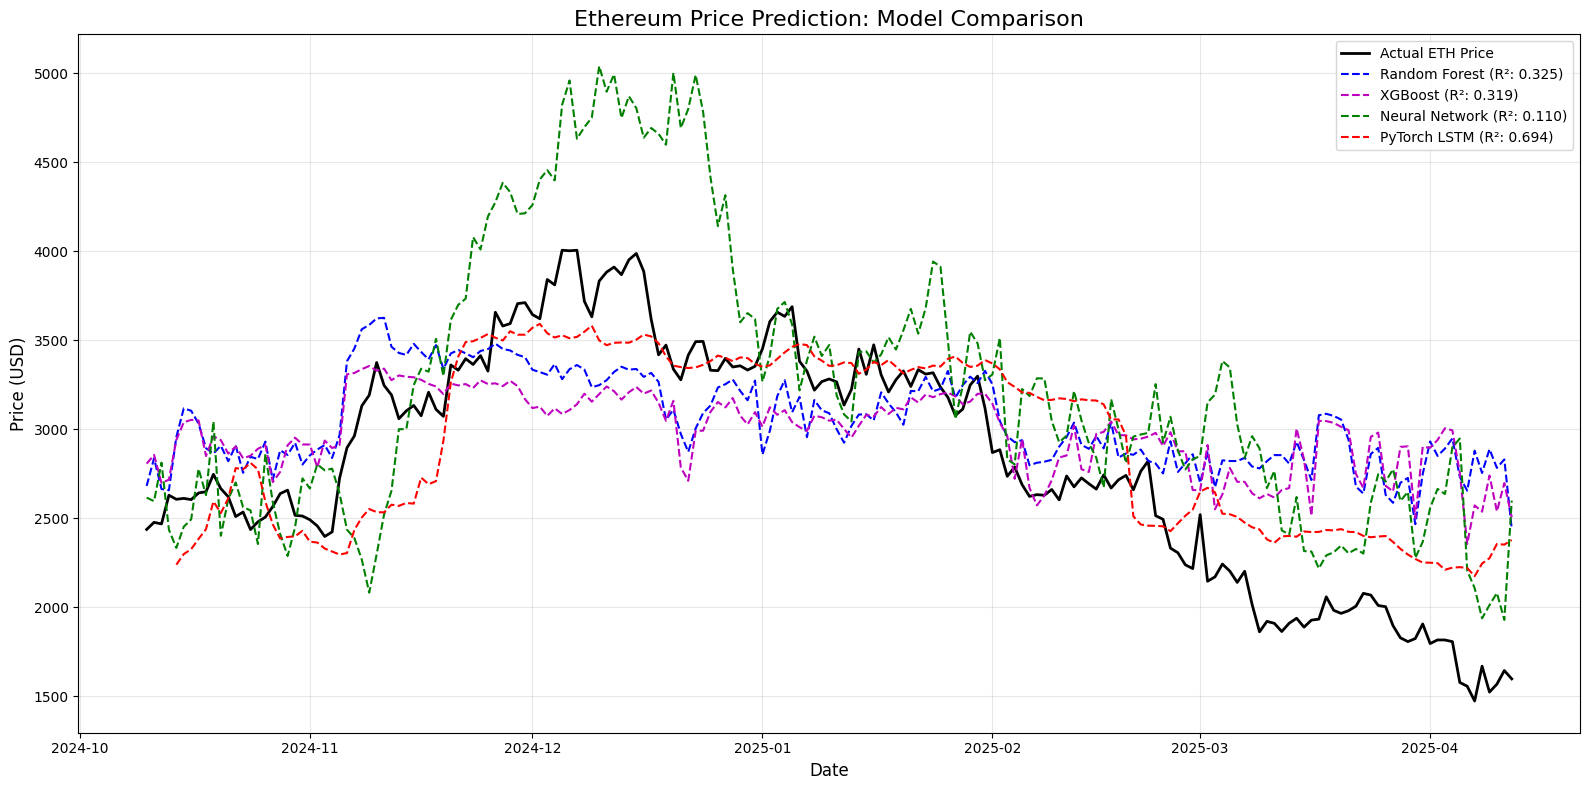


Feature category importance:
Market features: 69.31%
Block features: 11.70%
Transaction features: 16.28%
Other features: 2.72%

Top 5 market features:
                  Feature  Importance
12            volume_ma_7    0.258900
13           volume_ma_30    0.233937
8   volume_volatility_30d    0.037129
11           momentum_30d    0.036858
5    price_volatility_30d    0.025301

Top 5 block features:
          Feature  Importance
17  gasLimit_mean    0.041512
15      size_mean    0.022965
24    gasUsed_sum    0.020089
16       size_max    0.019593
19  burntFees_sum    0.010614

Top 5 transaction features:
                       Feature  Importance
27       unique_recipients_sum    0.149936
23                tx_count_sum    0.008904
26  gas_utilization_ratio_mean    0.003939


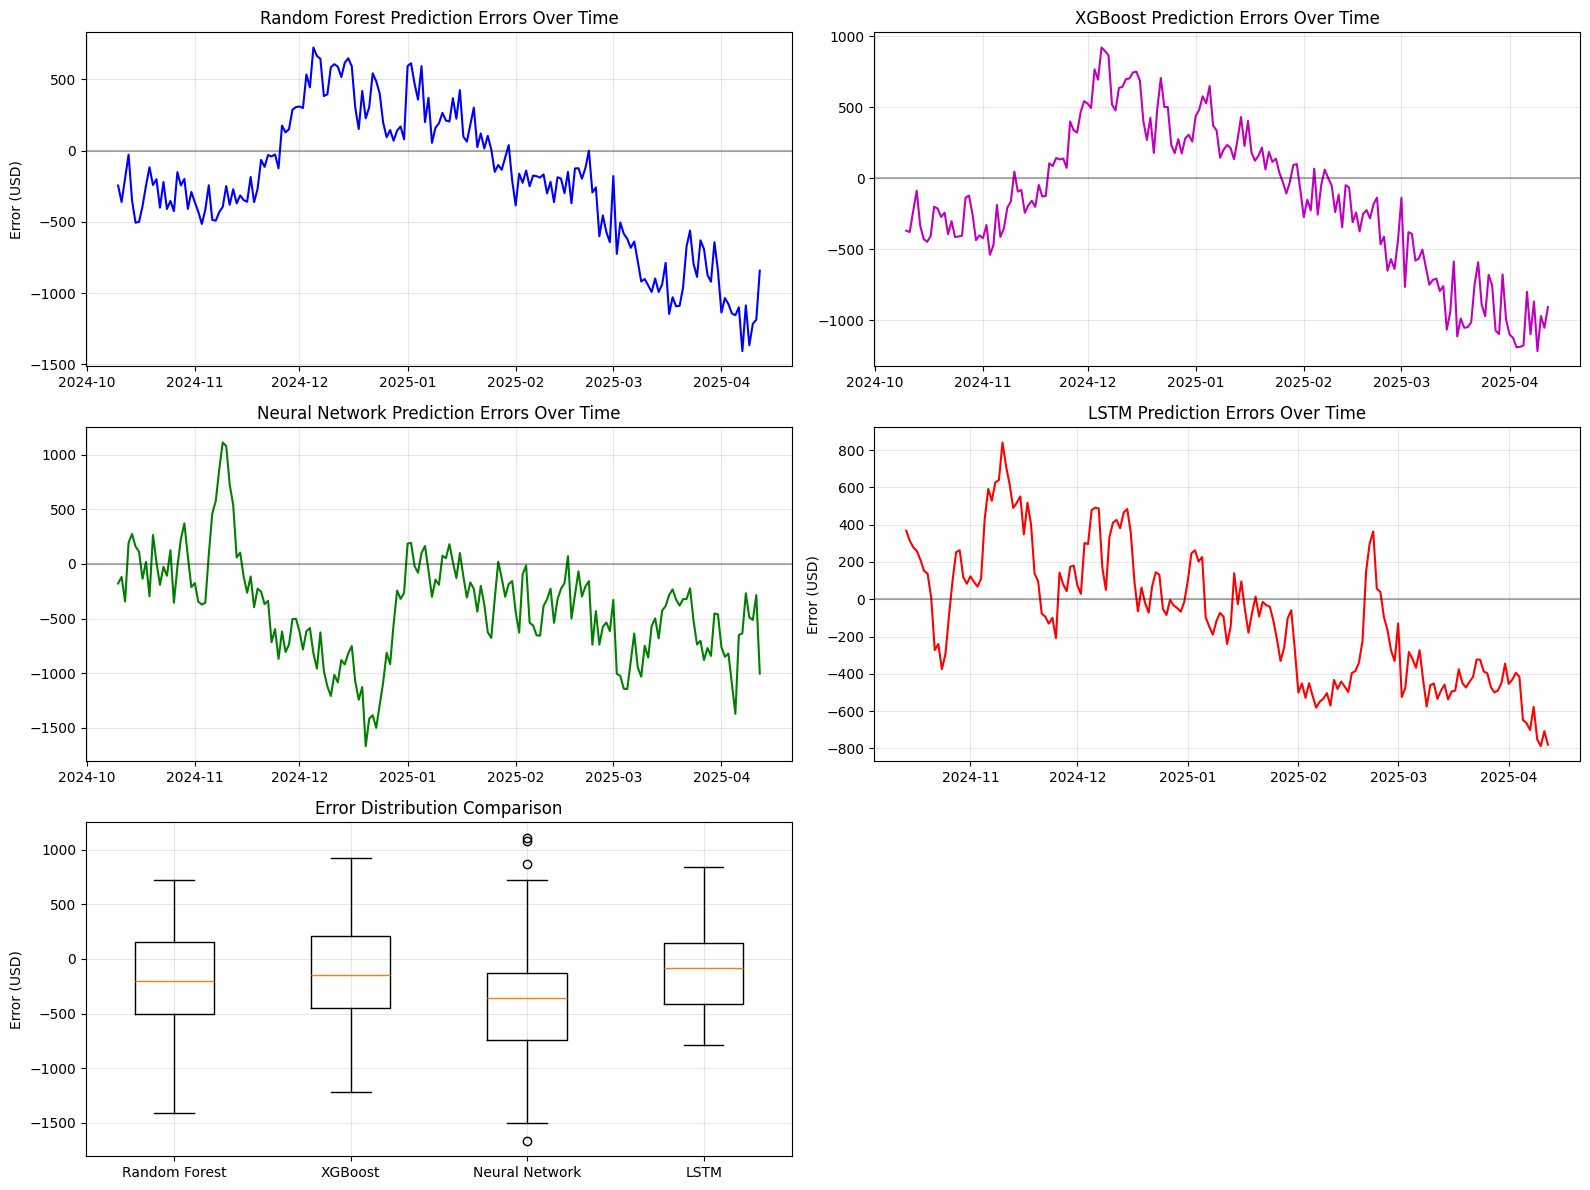


Best performing model: PyTorch LSTM
Best model RMSE: $364.91
Best model R²: 0.6944

-------------- Summary of Findings --------------
1. The PyTorch LSTM model provides the most accurate prediction of ETH price.
2. Feature importance by category: Market (69.31%), Block (11.70%), Transaction (16.28%).
3. The top 3 most predictive features are:
   1. volume_ma_7: 0.258900
   2. volume_ma_30: 0.233937
   3. unique_recipients_sum: 0.149936


In [ ]:
# PART 4: MODEL BUILDING

# 1. RANDOM FOREST MODEL
print("\n----- Training Random Forest Model with Hyperparameter Tuning ------")

from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# hyperparameter search space for Random Forest
rf_param_dist = {
    'n_estimators': [100, 200, 300, 500, 800],
    'max_depth': [8, 10, 12, 15, 20, None],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 3, 5],
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],
    'bootstrap': [True, False]
}

# Base Random Forest model
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Randomized search with cross-validation
rf_random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_dist,
    n_iter=50,  # Number of parameter settings sampled
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Performing Random Forest hyperparameter tuning...")
rf_random_search.fit(X_train, y_train)

# Best model
rf_model = rf_random_search.best_estimator_
print(f"Best RF parameters: {rf_random_search.best_params_}")

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Calculate metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)

print(f"Tuned Random Forest Performance:")
print(f"MAE: ${mae_rf:.2f}")
print(f"RMSE: ${rmse_rf:.2f}")
print(f"R²: {r2_rf:.4f}")
print(f"MAPE: {mape_rf*100:.2f}%")

model_results['Random Forest'] = {
    'mae': mae_rf,
    'rmse': rmse_rf,
    'r2': r2_rf,
    'mape': mape_rf,
    'predictions': y_pred_rf
}

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# 1.5 XGBOOST WITH COMPREHENSIVE HYPERPARAMETER TUNING
print("\n----- Training XGBoost Model with Enhanced Hyperparameter Tuning ------")

# More comprehensive XGBoost hyperparameter search
xgb_param_dist = {
    'n_estimators': [200, 300, 500, 800, 1000],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [1, 1.5, 2.0, 2.5]
}

# Base XGBoost model
xgb_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Randomized search
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_dist,
    n_iter=75,  # More iterations for XGBoost
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Performing XGBoost hyperparameter tuning...")
xgb_random_search.fit(X_train, y_train)

# Best model
xgb_model = xgb_random_search.best_estimator_
print(f"Best XGBoost parameters: {xgb_random_search.best_params_}")

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Calculate metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

print(f"Tuned XGBoost Performance:")
print(f"MAE: ${mae_xgb:.2f}")
print(f"RMSE: ${rmse_xgb:.2f}")
print(f"R²: {r2_xgb:.4f}")
print(f"MAPE: {mape_xgb*100:.2f}%")

model_results['XGBoost'] = {
    'mae': mae_xgb,
    'rmse': rmse_xgb,
    'r2': r2_xgb,
    'mape': mape_xgb,
    'predictions': y_pred_xgb
}

# 2. ENHANCED NEURAL NETWORK WITH HYPERPARAMETER TUNING
print("\n------ Training Neural Network Model with Enhanced Architecture ------")

tf.keras.backend.clear_session()

# Try different architectures and hyperparameters
def create_tuned_nn_model(input_dim,
                         hidden_layers=[128, 64, 32],
                         dropout_rates=[0.2, 0.1, 0.1],
                         learning_rate=0.001,
                         l2_reg=0.0001):
    """Create a neural network with tunable architecture"""
    model = Sequential()

    # Input layer
    model.add(Dense(hidden_layers[0], input_shape=(input_dim,)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rates[0]))

    # Hidden layers
    for i in range(1, len(hidden_layers)):
        model.add(Dense(hidden_layers[i],
                       kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())
        if i < len(dropout_rates):
            model.add(Dropout(dropout_rates[i]))

    # Output layer
    model.add(Dense(1))

    # Compile with adaptive learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

# Test multiple configurations
nn_configs = [
    {
        'hidden_layers': [128, 64, 32],
        'dropout_rates': [0.15, 0.1, 0.05],
        'learning_rate': 0.002,
        'l2_reg': 0.0001,
        'batch_size': 16,
        'epochs': 500
    },
    {
        'hidden_layers': [256, 128, 64],
        'dropout_rates': [0.2, 0.15, 0.1],
        'learning_rate': 0.001,
        'l2_reg': 0.0005,
        'batch_size': 32,
        'epochs': 400
    },
    {
        'hidden_layers': [64, 32],
        'dropout_rates': [0.1, 0.05],
        'learning_rate': 0.003,
        'l2_reg': 0.00005,
        'batch_size': 24,
        'epochs': 600
    }
]

best_nn_r2 = -np.inf
best_nn_model = None
best_nn_predictions = None

for i, config in enumerate(nn_configs):
    print(f"\nTesting NN configuration {i+1}/3:")
    print(f"Architecture: {config['hidden_layers']}")

    # Create model
    nn_model = create_tuned_nn_model(
        input_dim=X_train.shape[1],
        hidden_layers=config['hidden_layers'],
        dropout_rates=config['dropout_rates'],
        learning_rate=config['learning_rate'],
        l2_reg=config['l2_reg']
    )

    # Enhanced callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=150,
        restore_best_weights=True,
        verbose=0
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=30,
        min_lr=0.00001,
        verbose=0
    )

    # Train model
    history = nn_model.fit(
        X_train, y_train_scaled,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        validation_split=0.2,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    # Make predictions and evaluate
    y_pred_scaled = nn_model.predict(X_test, verbose=0).flatten()
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    r2_temp = r2_score(y_test, y_pred)
    print(f"Configuration {i+1} R²: {r2_temp:.4f}")

    if r2_temp > best_nn_r2:
        best_nn_r2 = r2_temp
        best_nn_model = nn_model
        best_nn_predictions = y_pred
        print(f"New best NN configuration!")

# Use best model results
y_pred_nn = best_nn_predictions

# Calculate metrics for best model
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)
mape_nn = mean_absolute_percentage_error(y_test, y_pred_nn)

print(f"\nBest Neural Network Performance:")
print(f"MAE: ${mae_nn:.2f}")
print(f"RMSE: ${rmse_nn:.2f}")
print(f"R²: {r2_nn:.4f}")
print(f"MAPE: {mape_nn*100:.2f}%")

model_results['Neural Network'] = {
    'mae': mae_nn,
    'rmse': rmse_nn,
    'r2': r2_nn,
    'mape': mape_nn,
    'predictions': y_pred_nn
}

# 3. PYTORCH LSTM WITH HYPERPARAMETER TUNING
print("\n------ Training Enhanced PyTorch Lightning LSTM Model ------")

# Enhanced LSTM class with more tunable parameters
class EnhancedETHPriceLSTM(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim=256, layer_dim=3, output_dim=1,
                 dropout_prob=0.2, learning_rate=0.0001, weight_decay=1e-5,
                 use_attention=False):
        super(EnhancedETHPriceLSTM, self).__init__()

        self.save_hyperparameters()

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.use_attention = use_attention

        # Enhanced LSTM with more capacity
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=layer_dim,
            batch_first=True,
            dropout=dropout_prob if layer_dim > 1 else 0,
            bidirectional=True
        )

        # Attention mechanism
        if use_attention:
            self.attention = nn.MultiheadAttention(
                embed_dim=hidden_dim * 2,
                num_heads=8,
                dropout=dropout_prob,
                batch_first=True
            )

        # Enhanced fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.LeakyReLU(0.1)
        self.dropout1 = nn.Dropout(dropout_prob)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.dropout2 = nn.Dropout(dropout_prob * 0.5)

        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.bn3 = nn.BatchNorm1d(hidden_dim // 4)
        self.dropout3 = nn.Dropout(dropout_prob * 0.3)

        self.fc4 = nn.Linear(hidden_dim // 4, output_dim)

        # Loss function with label smoothing
        self.loss_fn = nn.SmoothL1Loss()

        # For tracking metrics
        self.training_step_outputs = []
        self.validation_step_outputs = []

    def forward(self, x):
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)

        # Apply attention if enabled
        if self.use_attention:
            lstm_out, _ = self.attention(lstm_out, lstm_out, lstm_out)

        # Get last time step output
        out = lstm_out[:, -1, :]

        # Enhanced fully connected layers
        out = self.fc1(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout1(out)

        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout2(out)

        out = self.fc3(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.dropout3(out)

        out = self.fc4(out)

        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        self.training_step_outputs.append(loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        mae = torch.mean(torch.abs(y_hat - y))
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_mae', mae, prog_bar=True)
        self.validation_step_outputs.append(loss)
        return loss

    def on_train_epoch_end(self):
        if self.training_step_outputs:
            avg_loss = torch.stack(self.training_step_outputs).mean()
            self.log('train_loss_epoch', avg_loss, prog_bar=True)
            self.training_step_outputs.clear()

    def on_validation_epoch_end(self):
        if self.validation_step_outputs:
            avg_loss = torch.stack(self.validation_step_outputs).mean()
            self.log('val_loss_epoch', avg_loss, prog_bar=True)
            self.validation_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )

        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=50, T_mult=2, eta_min=1e-6
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch'
            }
        }

# Test different LSTM configurations
lstm_configs = [
    {
        'seq_length': 21,  # 3 weeks
        'hidden_dim': 256,
        'layer_dim': 3,
        'dropout_prob': 0.15,
        'learning_rate': 0.0005,
        'batch_size': 16,
        'use_attention': False
    },
    {
        'seq_length': 14,  # 2 weeks
        'hidden_dim': 512,
        'layer_dim': 2,
        'dropout_prob': 0.2,
        'learning_rate': 0.0003,
        'batch_size': 32,
        'use_attention': True
    },
    {
        'seq_length': 28,  # 4 weeks
        'hidden_dim': 128,
        'layer_dim': 4,
        'dropout_prob': 0.25,
        'learning_rate': 0.0008,
        'batch_size': 24,
        'use_attention': False
    }
]

best_lstm_r2 = -np.inf
best_lstm_model = None
best_lstm_predictions = None
best_lstm_config = None

for i, config in enumerate(lstm_configs):
    print(f"\nTesting LSTM configuration {i+1}/3:")
    print(f"Sequence length: {config['seq_length']}, Hidden dim: {config['hidden_dim']}")

    # Create sequences with current configuration
    seq_length = config['seq_length']
    X_lstm_config = []
    y_lstm_config = []

    for j in range(seq_length, len(X_scaled)):
        X_lstm_config.append(X_scaled[j-seq_length:j])
        y_lstm_config.append(y_scaled[j])

    X_lstm_config = np.array(X_lstm_config)
    y_lstm_config = np.array(y_lstm_config)

    # Train/test split
    train_size_lstm = int(len(X_lstm_config) * 0.8)
    X_train_lstm = X_lstm_config[:train_size_lstm]
    X_test_lstm = X_lstm_config[train_size_lstm:]
    y_train_lstm = y_lstm_config[:train_size_lstm]
    y_test_lstm = y_lstm_config[train_size_lstm:]

    # Get corresponding original y values
    y_test_lstm_orig = y[seq_length:][train_size_lstm:]

    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train_lstm)
    y_train_tensor = torch.FloatTensor(y_train_lstm).view(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test_lstm)
    y_test_tensor = torch.FloatTensor(y_test_lstm).view(-1, 1)

    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])

    # Initialize model
    model = EnhancedETHPriceLSTM(
        input_dim=X_train_lstm.shape[2],
        hidden_dim=config['hidden_dim'],
        layer_dim=config['layer_dim'],
        dropout_prob=config['dropout_prob'],
        learning_rate=config['learning_rate'],
        use_attention=config['use_attention']
    )

    # Training configuration
    early_stop_callback = PLEarlyStopping(
        monitor='val_loss',
        patience=100,
        verbose=False,
        mode='min'
    )

    checkpoint_callback = PLModelCheckpoint(
        monitor='val_loss',
        filename=f'eth_lstm_config_{i}',
        save_top_k=1,
        mode='min'
    )

    # Initialize trainer
    trainer = pl.Trainer(
        max_epochs=300,
        callbacks=[early_stop_callback, checkpoint_callback],
        accelerator='cpu',
        enable_progress_bar=False,
        log_every_n_steps=50
    )

    # Train model
    trainer.fit(model, train_loader, val_loader)

    # Load best model and evaluate
    if checkpoint_callback.best_model_path:
        best_config_model = EnhancedETHPriceLSTM.load_from_checkpoint(
            checkpoint_callback.best_model_path
        )
    else:
        best_config_model = model

    # Make predictions
    best_config_model.eval()
    with torch.no_grad():
        y_pred_scaled_config = best_config_model(X_test_tensor).numpy().flatten()

    # Inverse transform
    y_pred_config = target_scaler.inverse_transform(y_pred_scaled_config.reshape(-1, 1)).flatten()

    # Calculate R²
    r2_config = r2_score(y_test_lstm_orig, y_pred_config)
    print(f"Configuration {i+1} R²: {r2_config:.4f}")

    if r2_config > best_lstm_r2:
        best_lstm_r2 = r2_config
        best_lstm_model = best_config_model
        best_lstm_predictions = y_pred_config
        best_lstm_config = config
        # Store the test data for final evaluation
        final_y_test_lstm_orig = y_test_lstm_orig
        final_test_dates_lstm = df_merged['date'][seq_length:][train_size_lstm:]
        print(f"New best LSTM configuration!")

# Use best LSTM results
y_pred_lstm = best_lstm_predictions
y_test_lstm_orig = final_y_test_lstm_orig
test_dates_lstm = final_test_dates_lstm

# Calculate final metrics
mae_lstm = mean_absolute_error(y_test_lstm_orig, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_orig, y_pred_lstm))
r2_lstm = r2_score(y_test_lstm_orig, y_pred_lstm)
mape_lstm = mean_absolute_percentage_error(y_test_lstm_orig, y_pred_lstm)

print(f"\nBest Enhanced PyTorch LSTM Performance:")
print(f"Best configuration: {best_lstm_config}")
print(f"MAE: ${mae_lstm:.2f}")
print(f"RMSE: ${rmse_lstm:.2f}")
print(f"R²: {r2_lstm:.4f}")
print(f"MAPE: {mape_lstm*100:.2f}%")

model_results['PyTorch LSTM'] = {
    'mae': mae_lstm,
    'rmse': rmse_lstm,
    'r2': r2_lstm,
    'mape': mape_lstm,
    'predictions': y_pred_lstm
}

# PART 5: MODEL COMPARISON AND VISUALIZATION

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'MAE': [model_results[model]['mae'] for model in model_results],
    'RMSE': [model_results[model]['rmse'] for model in model_results],
    'R²': [model_results[model]['r2'] for model in model_results],
    'MAPE (%)': [model_results[model]['mape'] * 100 for model in model_results]
})

print("\nModel Performance Comparison:")
print(comparison_df)

# Save model comparison to CSV
comparison_df.to_csv(os.path.join(results_dir, 'model_comparison.csv'), index=False)

# Visualize predictions vs actual for all models
plt.figure(figsize=(16, 8))

# Plot actual prices
plt.plot(test_dates, y_test, 'k-', label='Actual ETH Price', linewidth=2)

# Plot predictions for Random Forest
plt.plot(test_dates[:len(y_pred_rf)], y_pred_rf, 'b--',
         label=f'Random Forest (R²: {r2_rf:.3f})', linewidth=1.5)

# Plot predictions for XGBoost
plt.plot(test_dates[:len(y_pred_xgb)], y_pred_xgb, 'm--',
         label=f'XGBoost (R²: {r2_xgb:.3f})', linewidth=1.5)

# Plot predictions for Neural Network
plt.plot(test_dates[:len(y_pred_nn)], y_pred_nn, 'g--',
         label=f'Neural Network (R²: {r2_nn:.3f})', linewidth=1.5)

# Plot predictions for LSTM
plt.plot(test_dates_lstm[:len(y_pred_lstm)], y_pred_lstm, 'r--',
         label=f'PyTorch LSTM (R²: {r2_lstm:.3f})', linewidth=1.5)

plt.title('Ethereum Price Prediction: Model Comparison', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'eth_price_predictions_comparison.png'), dpi=300)
plt.show()
plt.close()

# Categorize features
market_features = [col for col in feature_names if any(term in col for term in
                                                     ['price_', 'trading_volume', 'rsi_', 'momentum_', 'volume_ma_',
                                                      'volatility_'])]

block_features = [col for col in feature_names if any(term in col for term in
                                                    ['size', 'gasLimit', 'gasUsed', 'burntFees', 'tipsFees', 'baseFeePerGas'])]

tx_features = [col for col in feature_names if any(term in col for term in
                                                 ['tx_count', 'total_gasUsed', 'avg_gasPrice', 'total_value',
                                                  'avg_baseFeePerGas', 'gas_utilization_ratio', 'unique_senders',
                                                  'unique_recipients', 'avg_maxFeePerGas', 'avg_maxPriorityFeePerGas'])]

# Calculate importance by category
market_importance = feature_importance[feature_importance['Feature'].isin(market_features)]
market_importance_sum = market_importance['Importance'].sum() if not market_importance.empty else 0

block_importance = feature_importance[feature_importance['Feature'].isin(block_features)]
block_importance_sum = block_importance['Importance'].sum() if not block_importance.empty else 0

tx_importance = feature_importance[feature_importance['Feature'].isin(tx_features)]
tx_importance_sum = tx_importance['Importance'].sum() if not tx_importance.empty else 0

other_features = [f for f in feature_names if f not in market_features and
                  f not in block_features and f not in tx_features]
other_importance = feature_importance[feature_importance['Feature'].isin(other_features)]
other_importance_sum = other_importance['Importance'].sum() if not other_importance.empty else 0

total_importance = feature_importance['Importance'].sum()

print("\nFeature category importance:")
print(f"Market features: {market_importance_sum/total_importance*100:.2f}%")
print(f"Block features: {block_importance_sum/total_importance*100:.2f}%")
print(f"Transaction features: {tx_importance_sum/total_importance*100:.2f}%")
print(f"Other features: {other_importance_sum/total_importance*100:.2f}%")

# Save feature importance by category
category_importance = pd.DataFrame({
    'Category': ['Market', 'Block', 'Transaction', 'Other'],
    'Importance (%)': [
        market_importance_sum/total_importance*100,
        block_importance_sum/total_importance*100,
        tx_importance_sum/total_importance*100,
        other_importance_sum/total_importance*100
    ]
})
category_importance.to_csv(os.path.join(results_dir, 'feature_category_importance.csv'), index=False)

# Save top features by category
top_market = market_importance.head(5)
print("\nTop 5 market features:")
print(top_market)
top_market.to_csv(os.path.join(results_dir, 'top_market_features.csv'), index=False)

top_block = block_importance.head(5)
print("\nTop 5 block features:")
print(top_block)
top_block.to_csv(os.path.join(results_dir, 'top_block_features.csv'), index=False)

top_tx = tx_importance.head(5)
print("\nTop 5 transaction features:")
print(top_tx)
top_tx.to_csv(os.path.join(results_dir, 'top_transaction_features.csv'), index=False)

# Create error analysis visualization
plt.figure(figsize=(16, 12))

# Calculate errors
rf_errors = y_test[:len(y_pred_rf)] - y_pred_rf
xgb_errors = y_test[:len(y_pred_xgb)] - y_pred_xgb
nn_errors = y_test[:len(y_pred_nn)] - y_pred_nn
lstm_errors = y_test_lstm_orig[:len(y_pred_lstm)] - y_pred_lstm

# Plot error distributions
plt.subplot(3, 2, 1)
plt.plot(test_dates[:len(rf_errors)], rf_errors, 'b-', label='Random Forest Error')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.title('Random Forest Prediction Errors Over Time')
plt.ylabel('Error (USD)')
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 2)
plt.plot(test_dates[:len(xgb_errors)], xgb_errors, 'm-', label='XGBoost Error')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.title('XGBoost Prediction Errors Over Time')
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 3)
plt.plot(test_dates[:len(nn_errors)], nn_errors, 'g-', label='Neural Network Error')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.title('Neural Network Prediction Errors Over Time')
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 4)
plt.plot(test_dates_lstm[:len(lstm_errors)], lstm_errors, 'r-', label='LSTM Error')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.title('LSTM Prediction Errors Over Time')
plt.ylabel('Error (USD)')
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 5)
plt.boxplot([rf_errors, xgb_errors, nn_errors, lstm_errors],
            labels=['Random Forest', 'XGBoost', 'Neural Network', 'LSTM'])
plt.title('Error Distribution Comparison')
plt.ylabel('Error (USD)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'eth_price_prediction_errors.png'), dpi=300)
plt.show()
plt.close()

# Identify best model
best_model = comparison_df.loc[comparison_df['R²'].idxmax(), 'Model']
best_rmse = comparison_df.loc[comparison_df['Model'] == best_model, 'RMSE'].values[0]
best_r2 = comparison_df.loc[comparison_df['Model'] == best_model, 'R²'].values[0]

print(f"\nBest performing model: {best_model}")
print(f"Best model RMSE: ${best_rmse:.2f}")
print(f"Best model R²: {best_r2:.4f}")

# Summary and conclusions
print("\n-------------- Summary of Findings --------------")
print(f"1. The {best_model} model provides the most accurate prediction of ETH price.")
print(f"2. Feature importance by category: Market ({market_importance_sum/total_importance*100:.2f}%), "
      f"Block ({block_importance_sum/total_importance*100:.2f}%), "
      f"Transaction ({tx_importance_sum/total_importance*100:.2f}%).")
print(f"3. The top 3 most predictive features are:")
for i, (feature, importance) in enumerate(zip(feature_importance.head(3)['Feature'], feature_importance.head(3)['Importance'])):
    print(f"   {i+1}. {feature}: {importance:.6f}")

In [ ]:
tx_df.head()


In [ ]:
tx_df.tail()


In [ ]:
blocks_df.head()


In [ ]:
blocks_df.tail()

In [ ]:
df_merged.head()

In [ ]:
df_merged.tail()


Actual vs Predicted Price Sample
First 10 day predictions:
        Date  Actual_Price  RF_Predicted  XGB_Predicted  NN_Predicted  \
0 2024-10-10       2383.86       2681.23    2806.280029   2615.510010   
1 2024-10-11       2436.51       2836.80    2855.389893   2595.389893   
2 2024-10-12       2476.52       2663.68    2697.760010   2811.909912   
3 2024-10-13       2467.68       2656.81    2716.489990   2435.399902   
4 2024-10-14       2628.90       2955.90    2939.469971   2332.679932   
5 2024-10-15       2606.02       3116.76    3039.080078   2451.989990   
6 2024-10-16       2611.10       3103.73    3052.270020   2493.310059   
7 2024-10-17       2604.27       3031.06    3048.810059   2777.370117   
8 2024-10-18       2641.55       2893.19    2849.320068   2629.659912   
9 2024-10-19       2648.66       2862.86    2959.959961   3042.500000   

   LSTM_Predicted  RF_Error  XGB_Error  NN_Error  LSTM_Error  RF_Error_Pct  \
0             NaN   -297.37    -422.43   -231.66         N

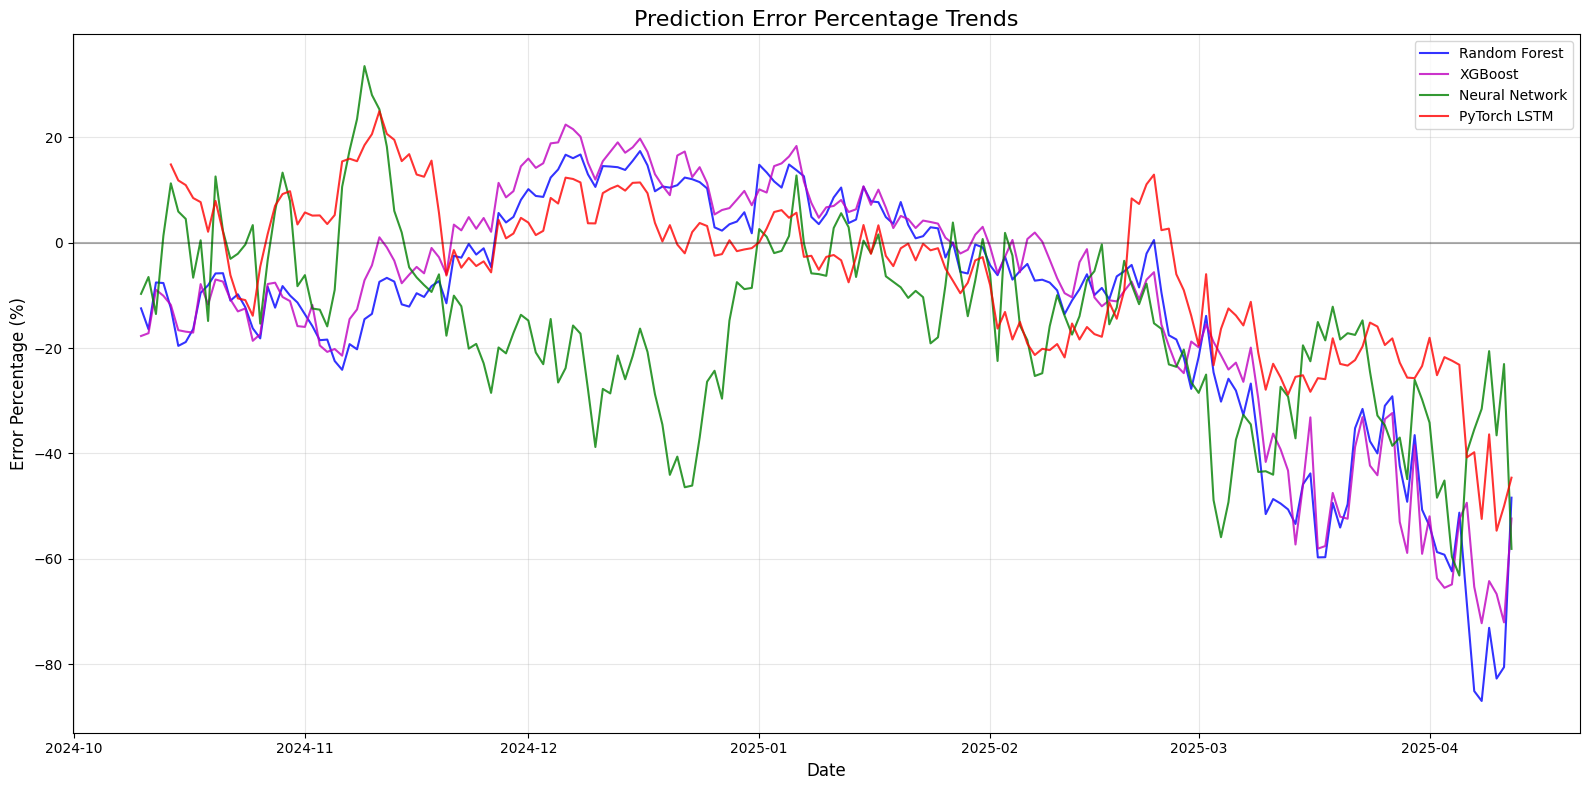


Average Absolute Error Percentages:
Random Forest: 18.44%
XGBoost: 18.18%
Neural Network: 18.51%
PyTorch LSTM: 12.05%


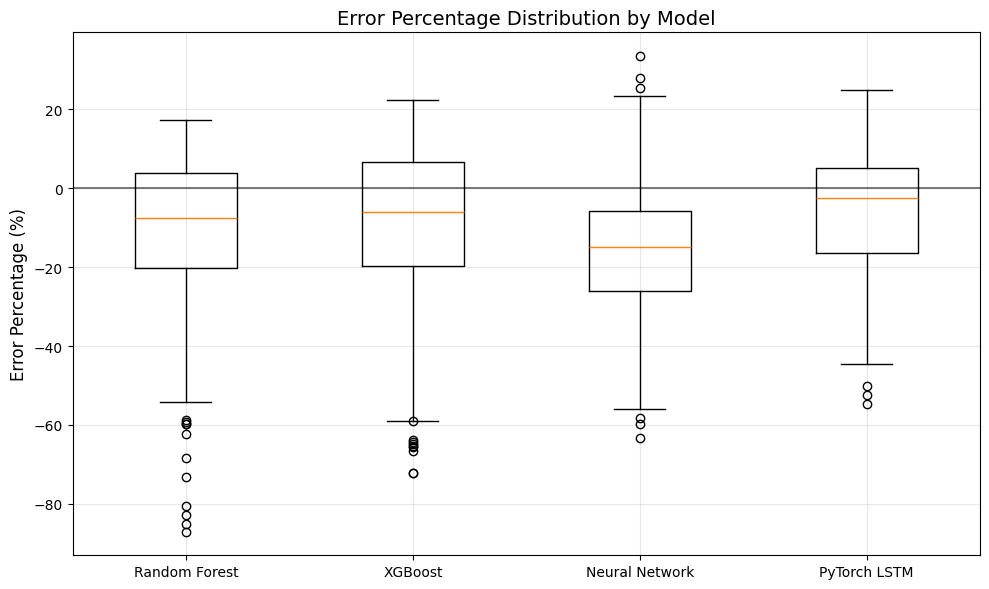

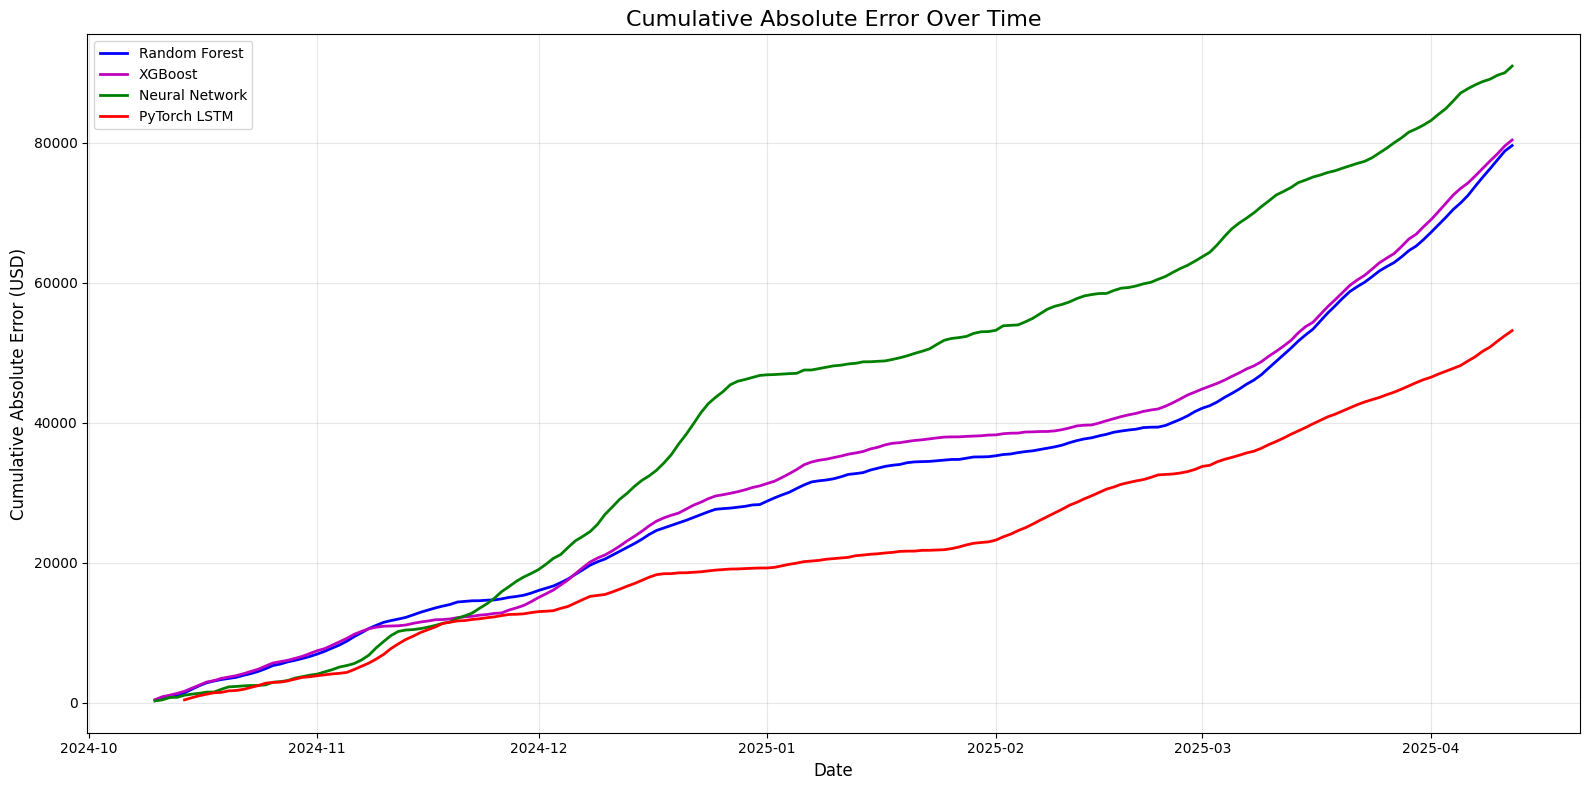

In [ ]:
eth_usd_clean = eth_usd_df.copy()
eth_usd_clean['Date'] = pd.to_datetime(eth_usd_clean['Date'])

# Create comparison DataFrame starting with test dates
comparison_results = pd.DataFrame({
    'Date': test_dates.reset_index(drop=True)
})

# Merge with actual prices from eth_usd_df using 'Close' column
comparison_results = pd.merge(
    comparison_results,
    eth_usd_clean[['Date', 'Close']],
    on='Date',
    how='left'
).rename(columns={'Close': 'Actual_Price'})

# Add model predictions
comparison_results['RF_Predicted'] = y_pred_rf
comparison_results['XGB_Predicted'] = y_pred_xgb
comparison_results['NN_Predicted'] = y_pred_nn

# Create LSTM prediction mapping
lstm_pred_df = pd.DataFrame({
    'Date': test_dates_lstm.reset_index(drop=True),
    'LSTM_Predicted': y_pred_lstm
})

# Merge LSTM predictions
comparison_results = pd.merge(comparison_results, lstm_pred_df, on='Date', how='left')

# Calculate errors using actual prices from eth_usd_df['Close']
comparison_results['RF_Error'] = comparison_results['Actual_Price'] - comparison_results['RF_Predicted']
comparison_results['XGB_Error'] = comparison_results['Actual_Price'] - comparison_results['XGB_Predicted']
comparison_results['NN_Error'] = comparison_results['Actual_Price'] - comparison_results['NN_Predicted']
comparison_results['LSTM_Error'] = comparison_results['Actual_Price'] - comparison_results['LSTM_Predicted']

# Calculate error percentages
comparison_results['RF_Error_Pct'] = (comparison_results['RF_Error'] / comparison_results['Actual_Price']) * 100
comparison_results['XGB_Error_Pct'] = (comparison_results['XGB_Error'] / comparison_results['Actual_Price']) * 100
comparison_results['NN_Error_Pct'] = (comparison_results['NN_Error'] / comparison_results['Actual_Price']) * 100
comparison_results['LSTM_Error_Pct'] = (comparison_results['LSTM_Error'] / comparison_results['Actual_Price']) * 100

# Display first 10 days
print("\nActual vs Predicted Price Sample")
print("First 10 day predictions:")
print(comparison_results.head(10).round(2))

# Display last 10 days
print("\nLast 10 day predictions:")
print(comparison_results.tail(10).round(2))

# Save detailed results
comparison_results.to_csv(os.path.join(results_dir, 'detailed_predictions_comparison.csv'), index=False)

# Plot error percentage trends
plt.figure(figsize=(16, 8))

# Plot RF error percentage
valid_rf = comparison_results.dropna(subset=['RF_Error_Pct'])
plt.plot(valid_rf['Date'], valid_rf['RF_Error_Pct'], 'b-',
         label='Random Forest', linewidth=1.5, alpha=0.8)

#Plot XG Boost error percentage
valid_xgb = comparison_results.dropna(subset=['XGB_Error_Pct'])
plt.plot(valid_xgb['Date'], valid_xgb['XGB_Error_Pct'], 'm-',
         label='XGBoost', linewidth=1.5, alpha=0.8)

# Plot NN error percentage
valid_nn = comparison_results.dropna(subset=['NN_Error_Pct'])
plt.plot(valid_nn['Date'], valid_nn['NN_Error_Pct'], 'g-',
         label='Neural Network', linewidth=1.5, alpha=0.8)

# Plot LSTM error percentage
valid_lstm = comparison_results.dropna(subset=['LSTM_Error_Pct'])
plt.plot(valid_lstm['Date'], valid_lstm['LSTM_Error_Pct'], 'r-',
         label='PyTorch LSTM', linewidth=1.5, alpha=0.8)

# Add zero line
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)

plt.title('Prediction Error Percentage Trends', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Error Percentage (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'error_percentage_trends.png'), dpi=300)
plt.show()
plt.close()

# Calculate average absolute error percentages
rf_avg_error_pct = valid_rf['RF_Error_Pct'].abs().mean()
xgb_avg_error_pct = valid_xgb['XGB_Error_Pct'].abs().mean()
nn_avg_error_pct = valid_nn['NN_Error_Pct'].abs().mean()
lstm_avg_error_pct = valid_lstm['LSTM_Error_Pct'].abs().mean()

print(f"\nAverage Absolute Error Percentages:")
print(f"Random Forest: {rf_avg_error_pct:.2f}%")
print(f"XGBoost: {xgb_avg_error_pct:.2f}%")
print(f"Neural Network: {nn_avg_error_pct:.2f}%")
print(f"PyTorch LSTM: {lstm_avg_error_pct:.2f}%")

# Create box plot of error percentages
plt.figure(figsize=(10, 6))

# Prepare data for box plot
error_data = []
labels = []

if not valid_rf.empty:
    error_data.append(valid_rf['RF_Error_Pct'])
    labels.append('Random Forest')

if not valid_xgb.empty:
    error_data.insert(1, valid_xgb['XGB_Error_Pct'])
    labels.insert(1, 'XGBoost')

if not valid_nn.empty:
    error_data.append(valid_nn['NN_Error_Pct'])
    labels.append('Neural Network')

if not valid_lstm.empty:
    error_data.append(valid_lstm['LSTM_Error_Pct'])
    labels.append('PyTorch LSTM')

plt.boxplot(error_data, labels=labels)
plt.ylabel('Error Percentage (%)', fontsize=12)
plt.title('Error Percentage Distribution by Model', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'error_pct_boxplot.png'), dpi=300)
plt.show()
plt.close()

# Create cumulative error plot
plt.figure(figsize=(16, 8))

# Calculate cumulative absolute errors
rf_cum_error = valid_rf['RF_Error'].abs().cumsum()
xgb_cum_error = valid_xgb['XGB_Error'].abs().cumsum()
nn_cum_error = valid_nn['NN_Error'].abs().cumsum()
lstm_cum_error = valid_lstm['LSTM_Error'].abs().cumsum()

plt.plot(valid_rf['Date'], rf_cum_error, 'b-', label='Random Forest', linewidth=2)
plt.plot(valid_xgb['Date'], xgb_cum_error, 'm-', label='XGBoost', linewidth=2)
plt.plot(valid_nn['Date'], nn_cum_error, 'g-', label='Neural Network', linewidth=2)
plt.plot(valid_lstm['Date'], lstm_cum_error, 'r-', label='PyTorch LSTM', linewidth=2)

plt.title('Cumulative Absolute Error Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Absolute Error (USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'cumulative_error.png'), dpi=300)
plt.show()
plt.close()

In [ ]:
eth_usd_df.head()

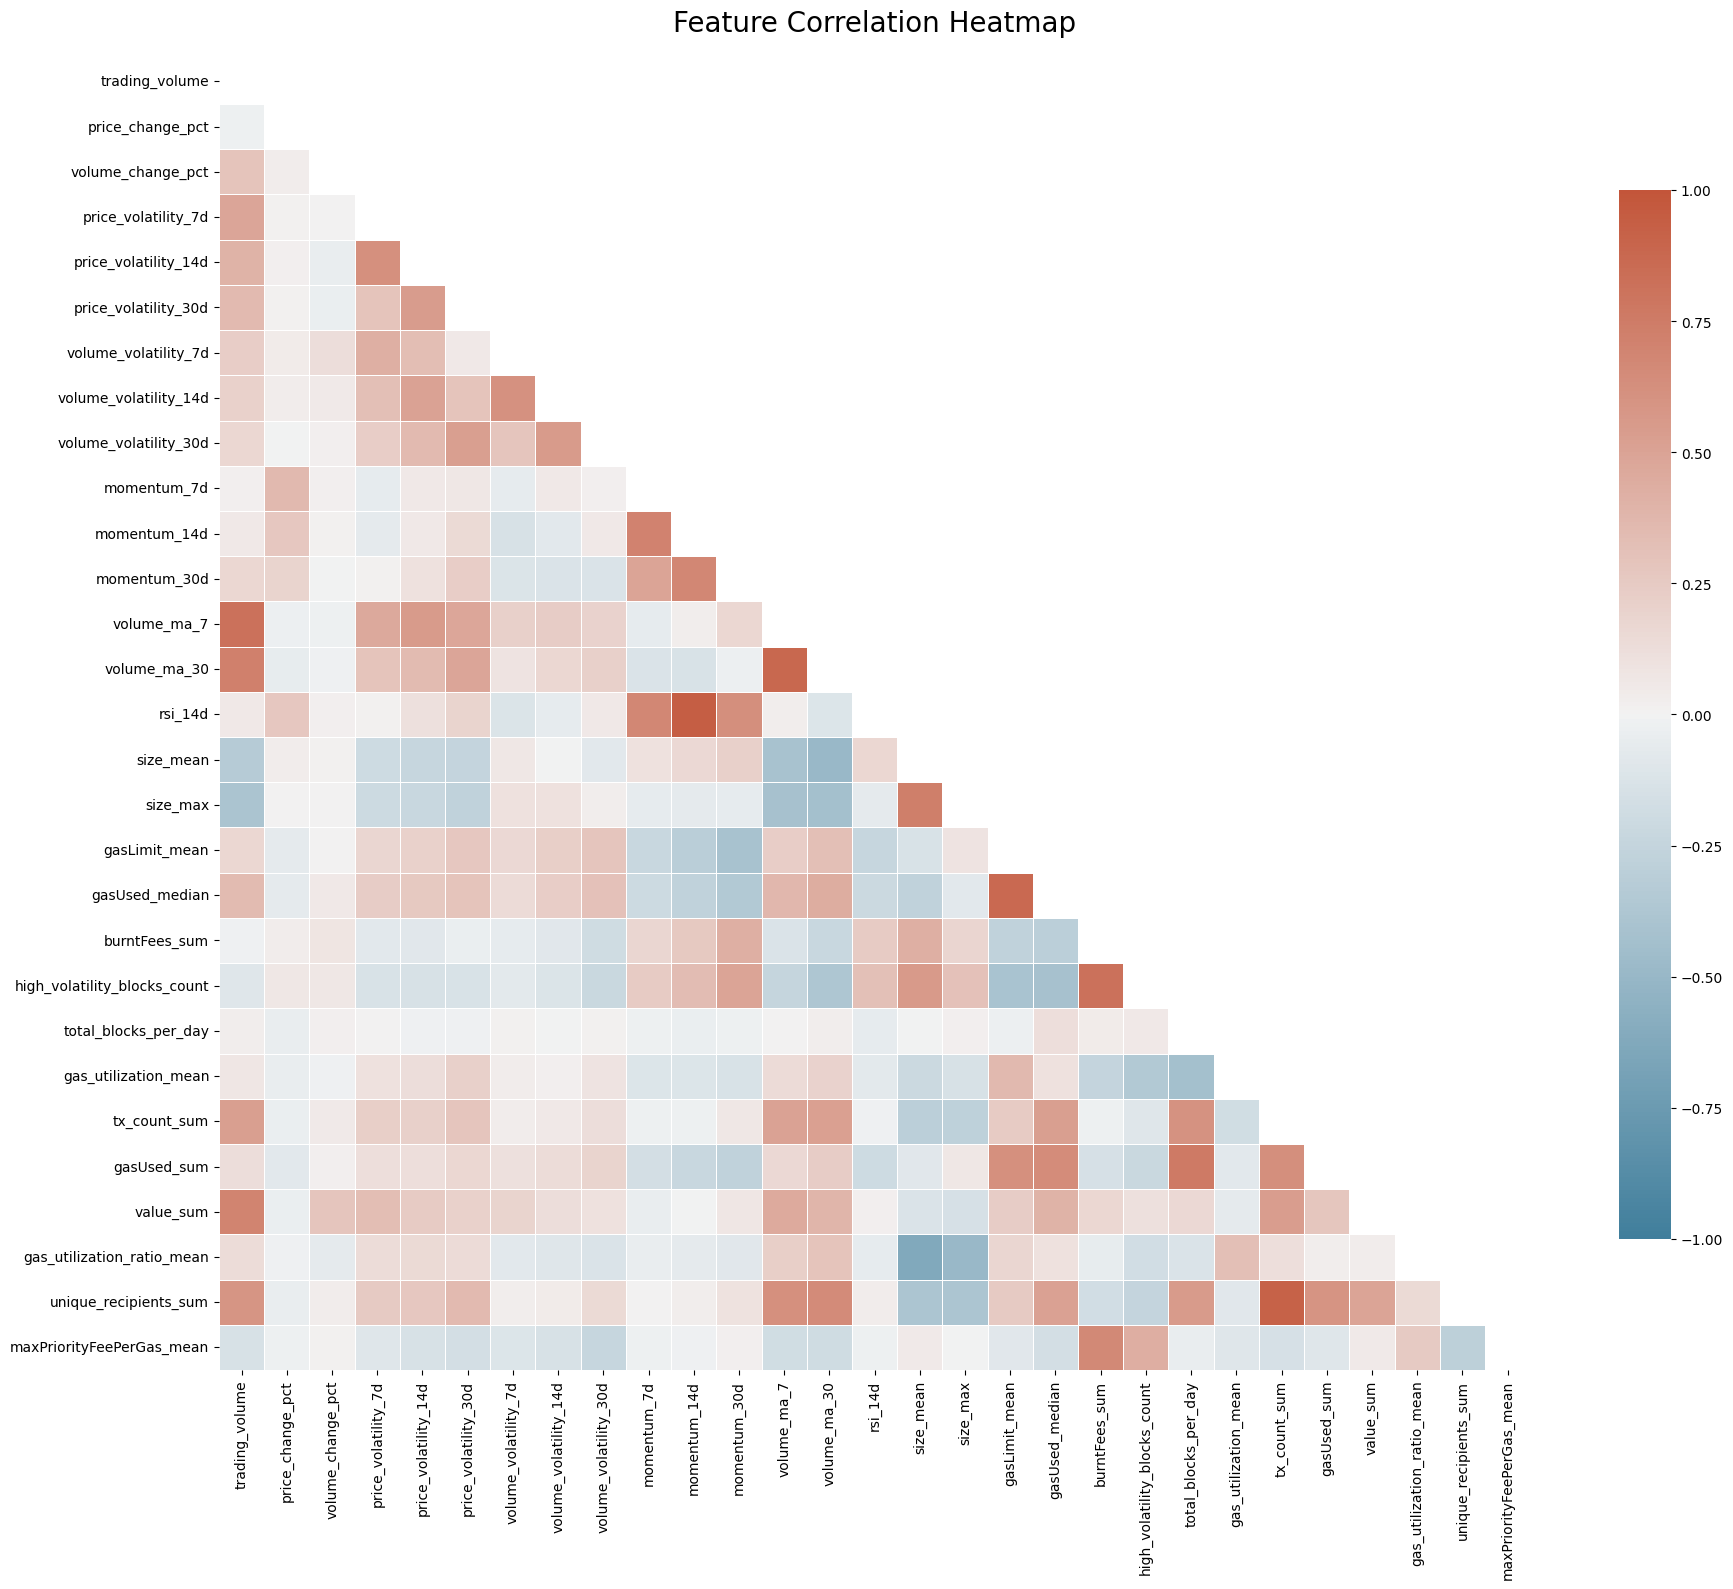

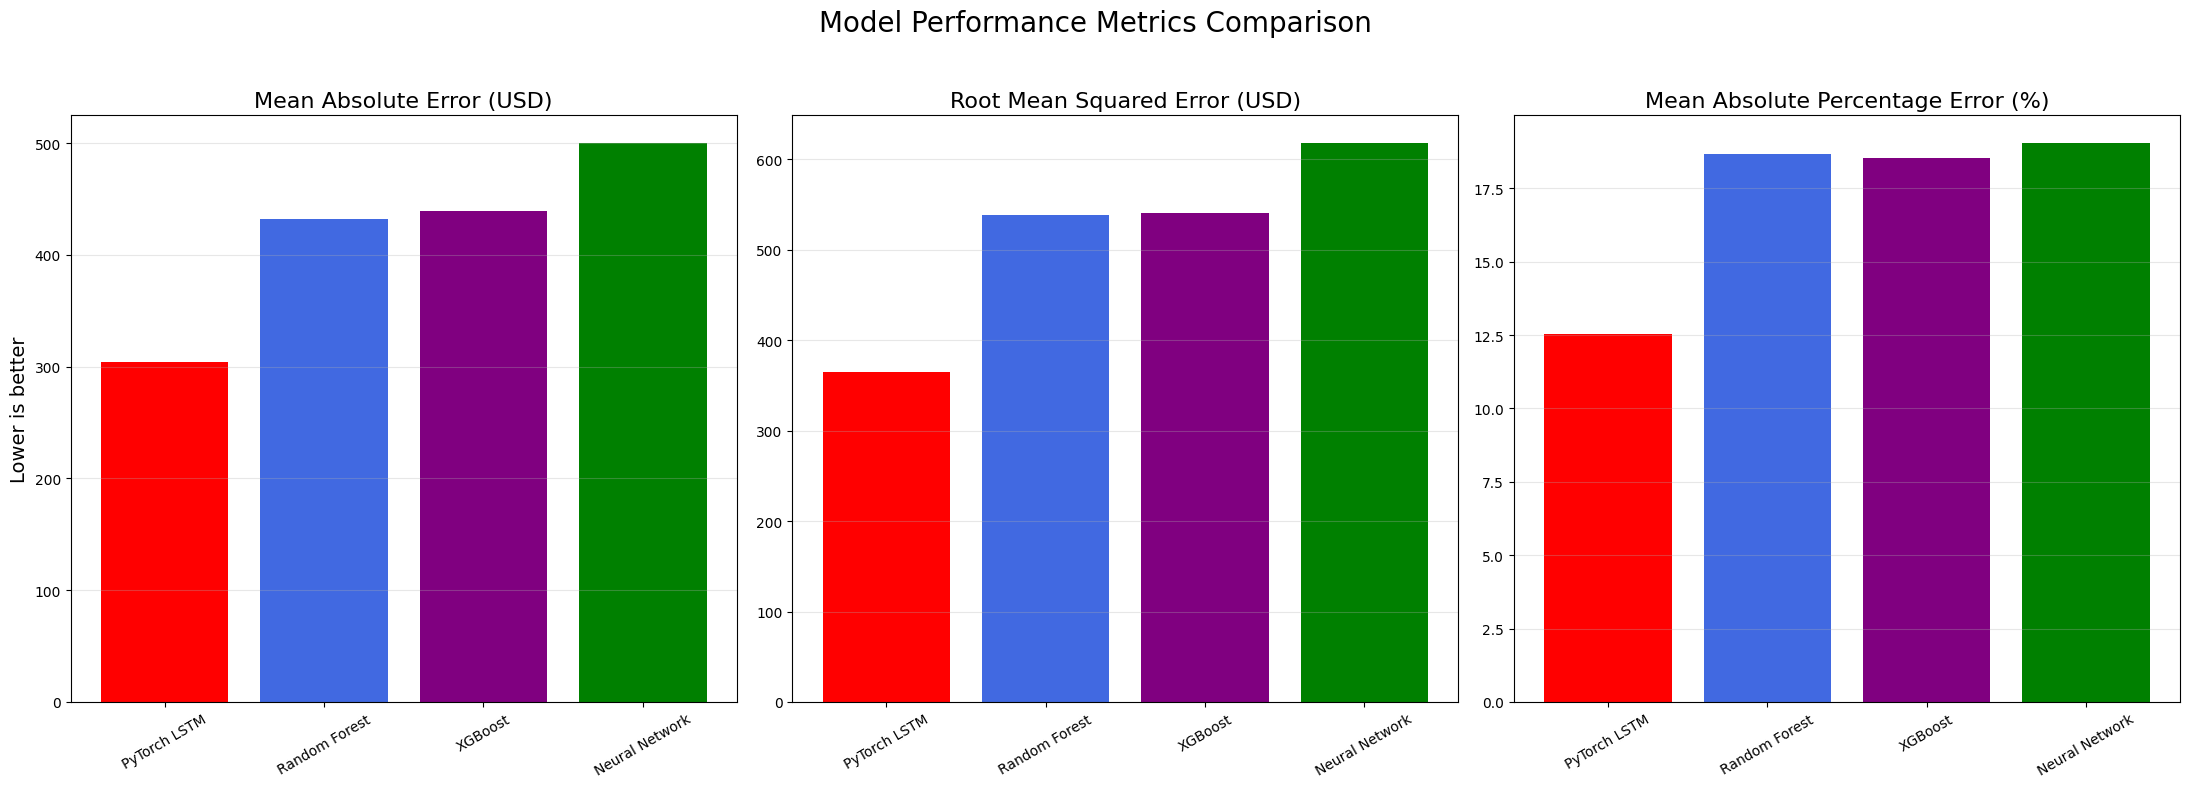

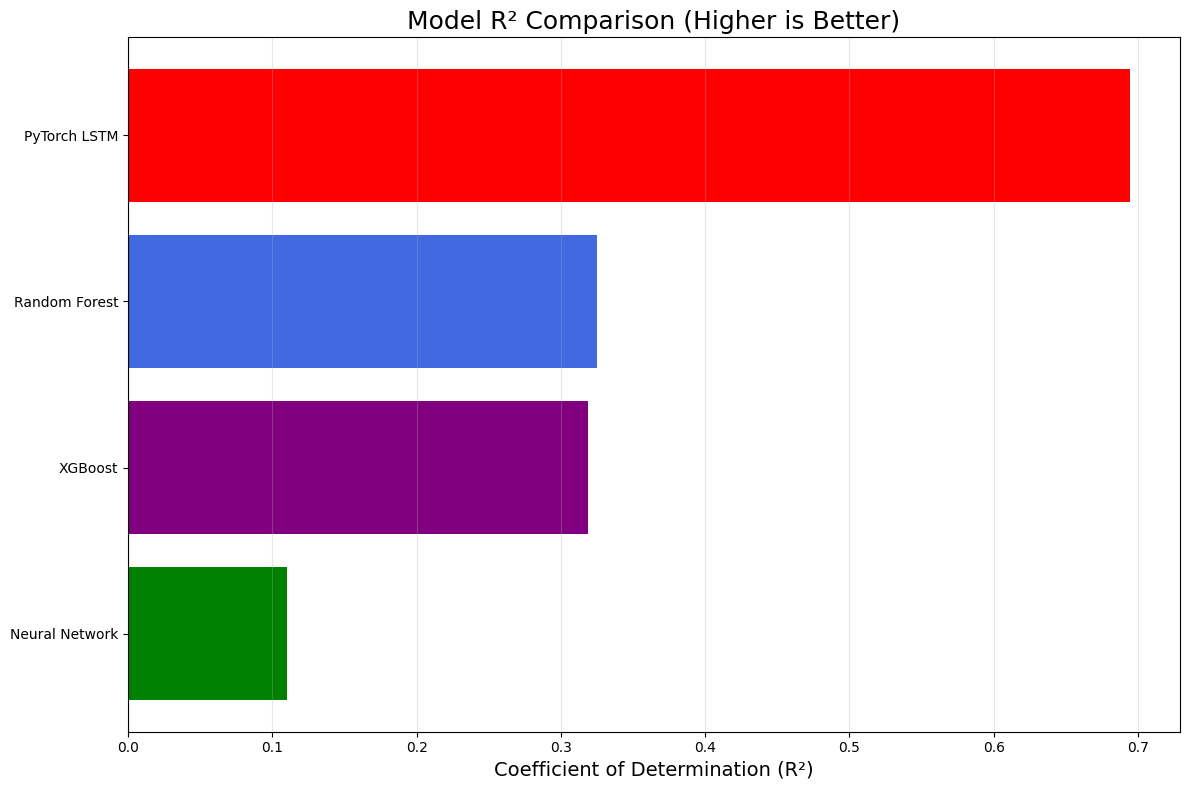

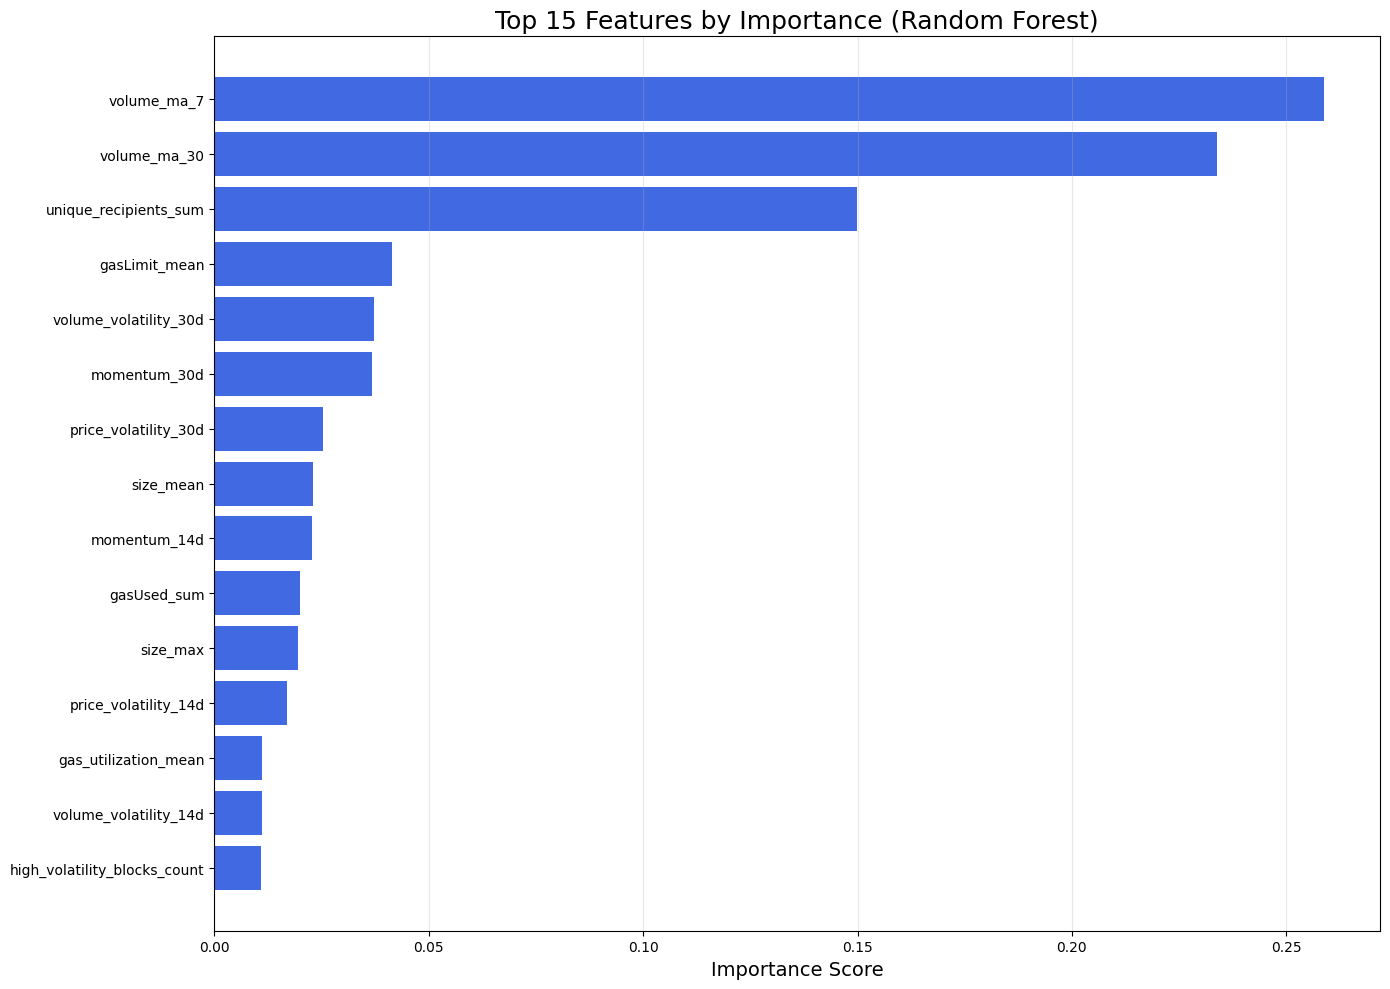

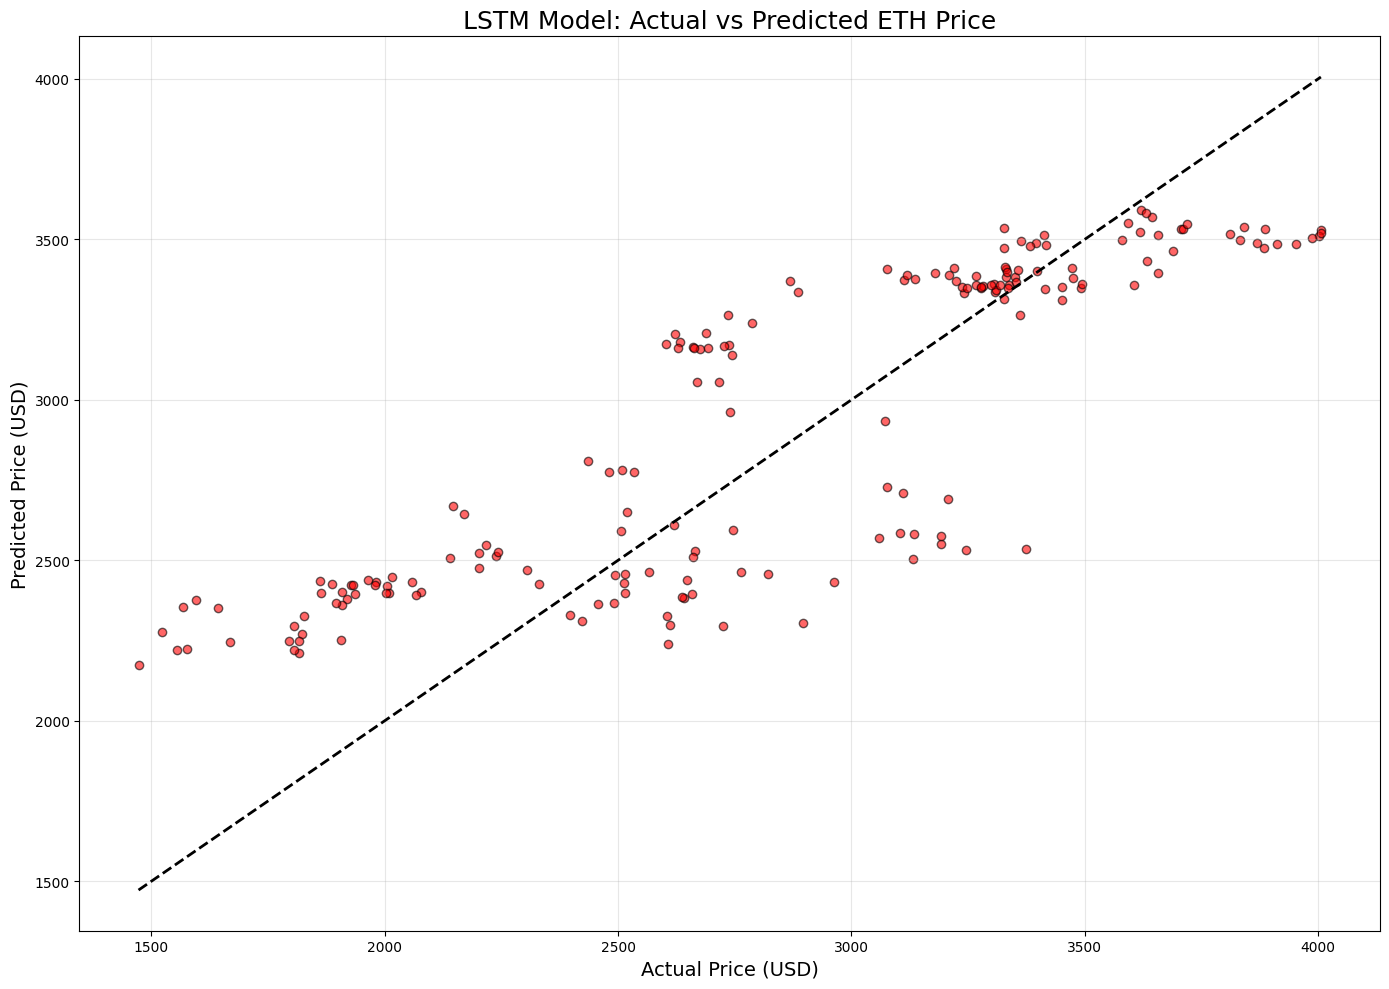

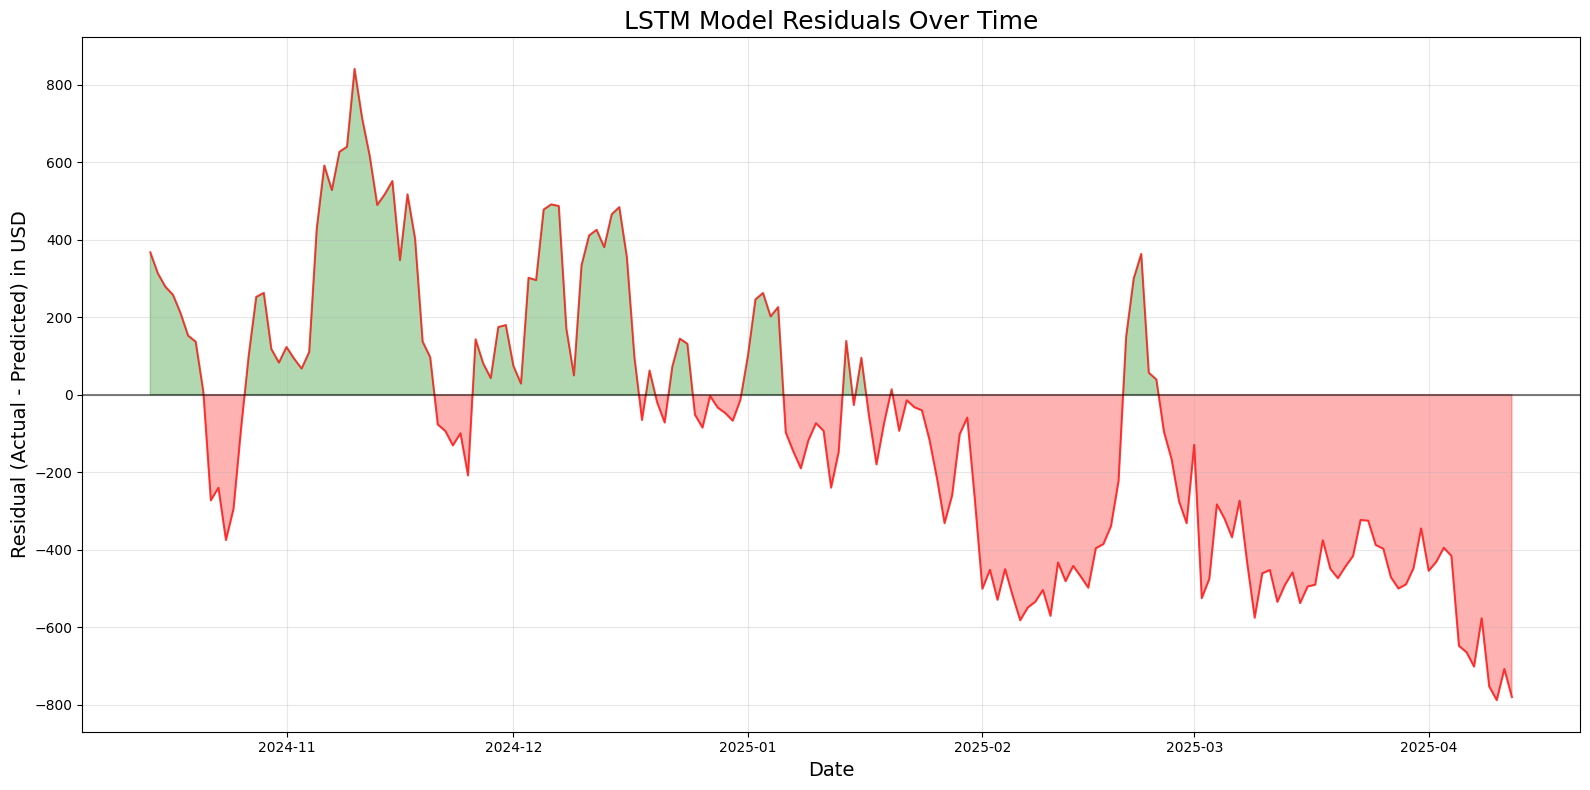

<Figure size 1600x1000 with 0 Axes>

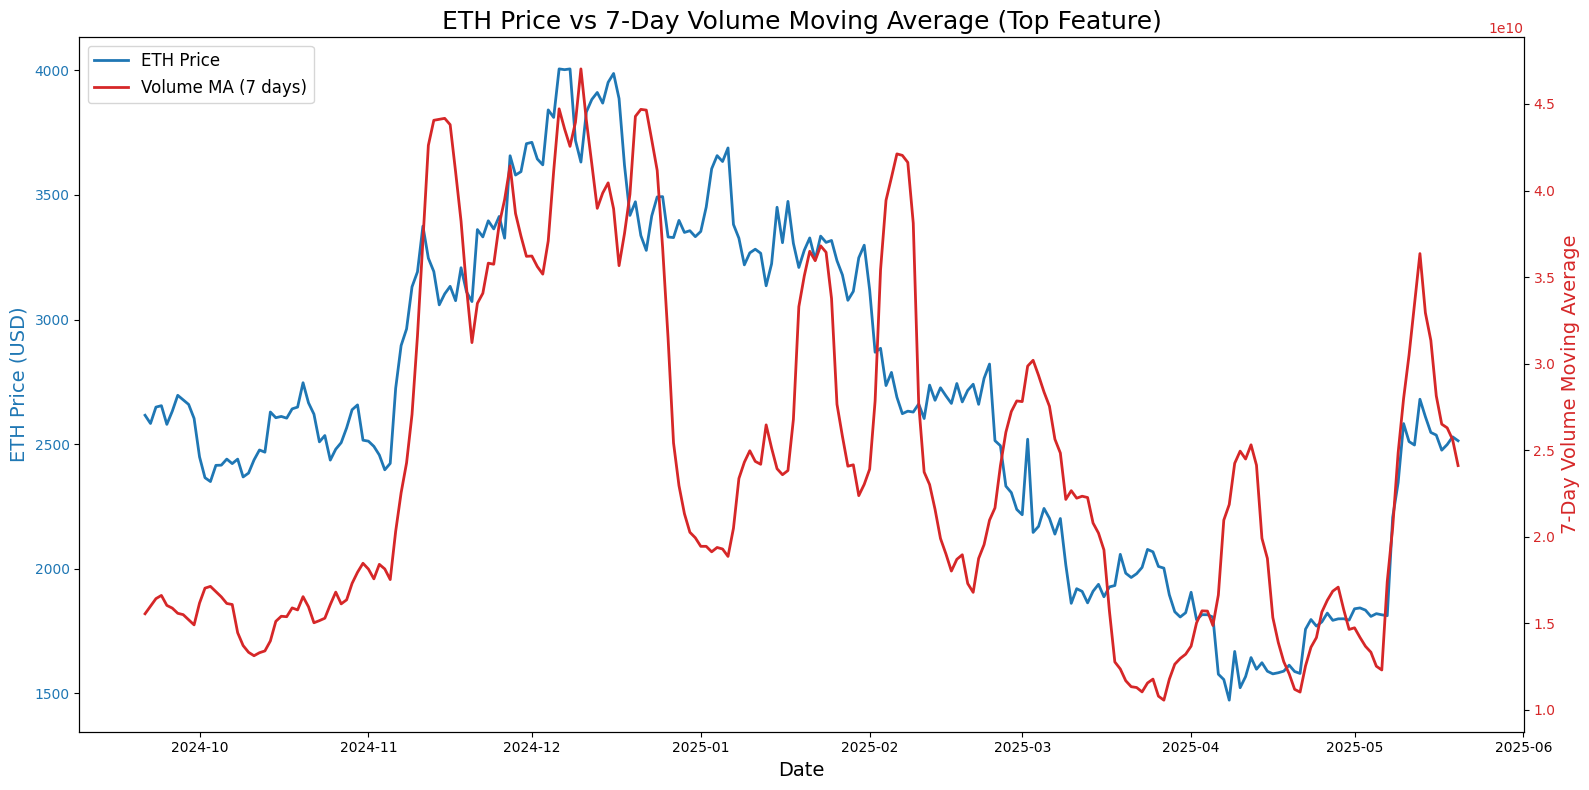

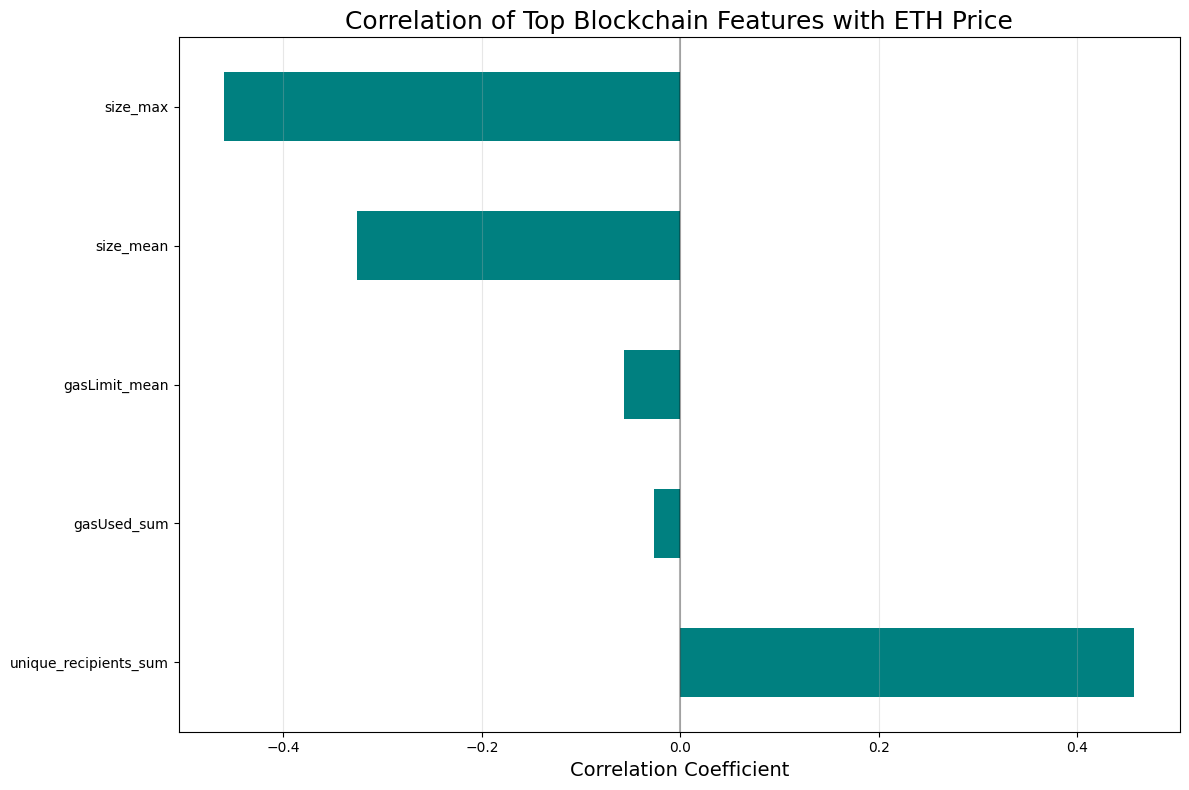

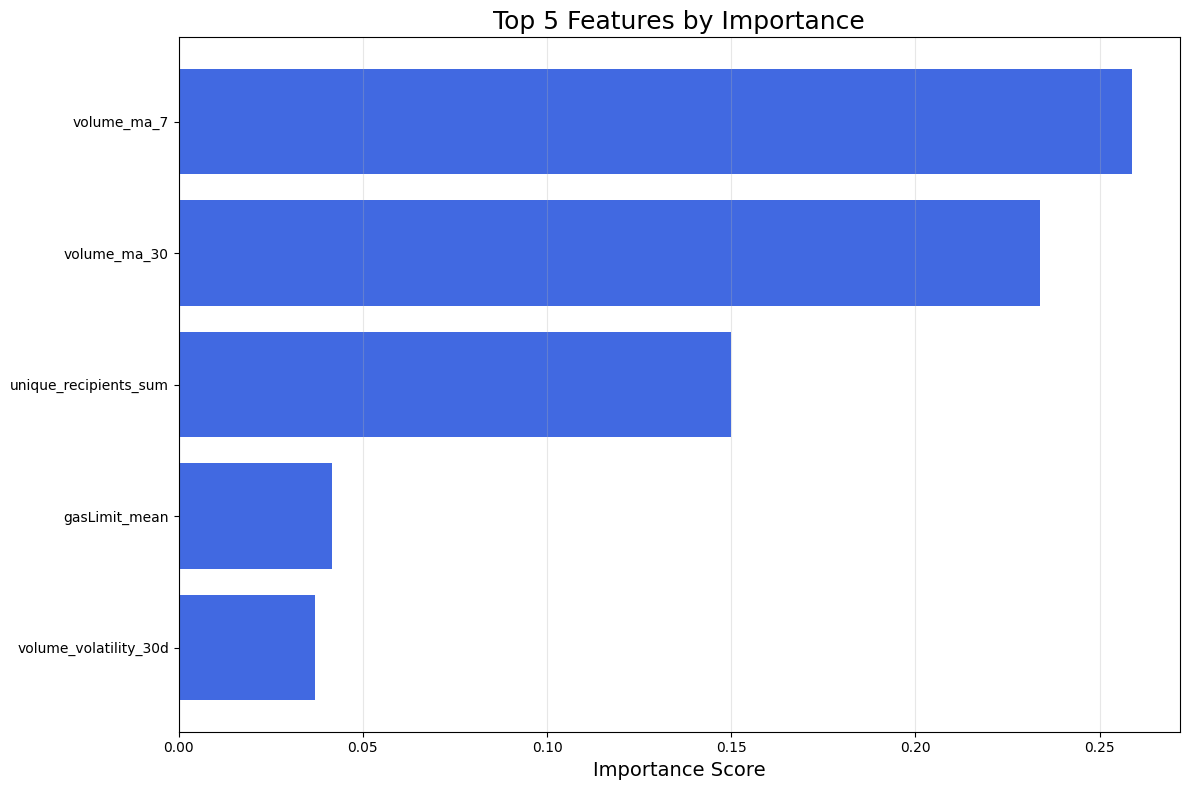

Done!


In [ ]:
# 1. Correlation Heat map of Features
plt.figure(figsize=(20, 16))
correlation = X.corr()
mask = np.triu(correlation)
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.title('Feature Correlation Heatmap', fontsize=20, pad=20)
heatmap = sns.heatmap(
    correlation,
    mask=mask,
    cmap=cmap,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    annot=False,
    cbar_kws={"shrink": .8}
)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'feature_correlation_heatmap.png'))
plt.show()
plt.close()

# 2. Bar Chart  - Model Evaluation Metrics Comparison
metrics = ['MAE', 'RMSE', 'MAPE (%)']
models = comparison_df['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(22, 8))
fig.suptitle('Model Performance Metrics Comparison', fontsize=20)

model_colors = {'Random Forest': 'royalblue', 'XGBoost': 'purple',
          'Neural Network': 'green', 'PyTorch LSTM': 'red'}

# Plot MAE
axes[0].bar(models, comparison_df['MAE'], color=[model_colors[m] for m in models])
axes[0].set_title('Mean Absolute Error (USD)', fontsize=16)
axes[0].set_ylabel('Lower is better', fontsize=14)
axes[0].tick_params(axis='x', rotation=30)
axes[0].grid(axis='y', alpha=0.3)

# Plot RMSE
axes[1].bar(models, comparison_df['RMSE'], color=[model_colors[m] for m in models])
axes[1].set_title('Root Mean Squared Error (USD)', fontsize=16)
axes[1].tick_params(axis='x', rotation=30)
axes[1].grid(axis='y', alpha=0.3)

# Plot MAPE
axes[2].bar(models, comparison_df['MAPE (%)'], color=[model_colors[m] for m in models])
axes[2].set_title('Mean Absolute Percentage Error (%)', fontsize=16)
axes[2].tick_params(axis='x', rotation=30)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(results_dir, 'model_metrics_comparison.png'))
plt.show()
plt.close()

# 3. R Sq Comparison - Bar Chart
plt.figure(figsize=(12, 8))

model_colors = {
    'Random Forest': 'royalblue',
    'XGBoost': 'purple',
    'Neural Network': 'green',
    'PyTorch LSTM': 'red'
}

# sort by performance
df_sorted = comparison_df.sort_values('R²', ascending=True)
bars = plt.barh(df_sorted['Model'], df_sorted['R²'], color=[model_colors[m] for m in df_sorted['Model']])

plt.axvline(x=0, color='black', linestyle='-', alpha=0.7)
plt.title('Model R² Comparison (Higher is Better)', fontsize=18)
plt.xlabel('Coefficient of Determination (R²)', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'r2_comparison.png'))
plt.show()
plt.close()

# 4. Feature Importance Visualization (Top 15) Random Forest
plt.figure(figsize=(14, 10))
top_features = feature_importance.head(15)

plt.barh(top_features['Feature'], top_features['Importance'], color='royalblue')
plt.title('Top 15 Features by Importance (Random Forest)', fontsize=18)
plt.xlabel('Importance Score', fontsize=14)
plt.gca().invert_yaxis()  # To have highest importance at the top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'top_feature_importance.png'))
plt.show()
plt.close()


# 5. Scatter Plots for Actual vs Predicted Prices (LSTM)
plt.figure(figsize=(14, 10))

plt.scatter(y_test_lstm_orig, y_pred_lstm, alpha=0.6, color='red', edgecolors='black')

min_val = min(y_test_lstm_orig.min(), y_pred_lstm.min())
max_val = max(y_test_lstm_orig.max(), y_pred_lstm.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

plt.title('LSTM Model: Actual vs Predicted ETH Price', fontsize=18)
plt.xlabel('Actual Price (USD)', fontsize=14)
plt.ylabel('Predicted Price (USD)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'lstm_actual_vs_predicted.png'))
plt.show()
plt.close()

# 6. Residuals for LSTM Model Over time
plt.figure(figsize=(16, 8))


lstm_residuals = y_test_lstm_orig - y_pred_lstm

plt.plot(test_dates_lstm[:len(lstm_residuals)], lstm_residuals, 'r-', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.5)
plt.fill_between(test_dates_lstm[:len(lstm_residuals)], lstm_residuals, 0,
                where=(lstm_residuals > 0), color='green', alpha=0.3, interpolate=True)
plt.fill_between(test_dates_lstm[:len(lstm_residuals)], lstm_residuals, 0,
                where=(lstm_residuals <= 0), color='red', alpha=0.3, interpolate=True)

plt.title('LSTM Model Residuals Over Time', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residual (Actual - Predicted) in USD', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'lstm_residuals.png'))
plt.show()
plt.close()


# 7. Price vs Volume MA (Top Feature)

market_data = eth_market[['date', 'eth_price', 'volume_ma_7']].copy()
market_data = market_data.iloc[train_size:].reset_index(drop=True)  # Use test period only

plt.figure(figsize=(16, 10))


fig, ax1 = plt.subplots(figsize=(16, 8))




color = 'tab:blue'
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('ETH Price (USD)', color=color, fontsize=14)
line1 = ax1.plot(market_data['date'], market_data['eth_price'], color=color, lw=2, label='ETH Price')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('7-Day Volume Moving Average', color=color, fontsize=14)
line2 = ax2.plot(market_data['date'], market_data['volume_ma_7'], color=color, lw=2, label='Volume MA (7 days)')
ax2.tick_params(axis='y', labelcolor=color)


lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=12)

plt.title('ETH Price vs 7-Day Volume Moving Average (Top Feature)', fontsize=18)
plt.grid(False)
fig.tight_layout()
plt.savefig(os.path.join(results_dir, 'price_vs_top_feature.png'))
plt.show()
plt.close()

# 8. Correlation Between Price and Top Blockchain Features
top_blockchain_features = []

for feature in feature_importance['Feature']:
    if feature in block_features or feature in tx_features:
        top_blockchain_features.append(feature)
    if len(top_blockchain_features) >= 5:
        break

price_blockchain_corr = pd.DataFrame()
price_blockchain_corr['eth_price'] = df_merged['target_price_next_day']
for feature in top_blockchain_features:
    price_blockchain_corr[feature] = df_merged[feature]


corr_matrix = price_blockchain_corr.corr()
corr_with_price = corr_matrix['eth_price'].drop('eth_price').sort_values(ascending=False)

plt.figure(figsize=(12, 8))
corr_with_price.plot(kind='barh', color='teal')
plt.title('Correlation of Top Blockchain Features with ETH Price', fontsize=18)
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'blockchain_price_correlation.png'))
plt.show()
plt.close()


# 9. tpp 5 Feature Importance
plt.figure(figsize=(12, 8))
top5_features = feature_importance.head(5)
plt.barh(top5_features['Feature'], top5_features['Importance'], color='royalblue')
plt.title('Top 5 Features by Importance', fontsize=18)
plt.xlabel('Importance Score', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'top5_feature_importance.png'), dpi=300)
plt.show()
plt.close()
print("Done!")